In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy
import calendar

import os

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.deterministic import DeterministicProcess

In [2]:
from utils.reg_helper_functions import *
from utils.reg_helper_functions import regression_metrics_df, calculate_cv_metrics_regression, combine_and_format_metrics
from utils.reg_helper_functions import plot_regression_models_metrics, plot_residuals, plot_residuals_sns
from utils.reg_helper_functions import plot_learning_curves_reg, plot_regression_metrics

from utils.helper_functions import *
from utils.helper_functions import plot_numerical_feature_comparison, plot_feature_distributions
from utils.helper_functions import plot_category_distribution, plot_category_distribution_by_group

In [3]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [4]:
# Root data files
data_folder = 'data/'
df_train = pd.read_csv(data_folder+'train_join.csv')

/tmp/ipykernel_119346/649059826.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(data_folder+'train_join.csv')


In [5]:
df_train.head()

date  store_nbr  item_nbr  unit_sales  onpromotion        family  \
0  2014-04-01          1    103520         1.0        False     GROCERY I   
1  2014-04-01          1    103665         3.0        False  BREAD/BAKERY   
2  2014-04-01          1    105574         1.0        False     GROCERY I   
3  2014-04-01          1    105575        11.0        False     GROCERY I   
4  2014-04-01          1    105577         4.0        False     GROCERY I   

   perishable type_store  cluster type_holiday  transferred  
0           0          D       13      Holiday        False  
1           1          D       13      Holiday        False  
2           0          D       13      Holiday        False  
3           0          D       13      Holiday        False  
4           0          D       13      Holiday        False

In [6]:
df_train["date"] = pd.to_datetime(df_train.date, cache=True)

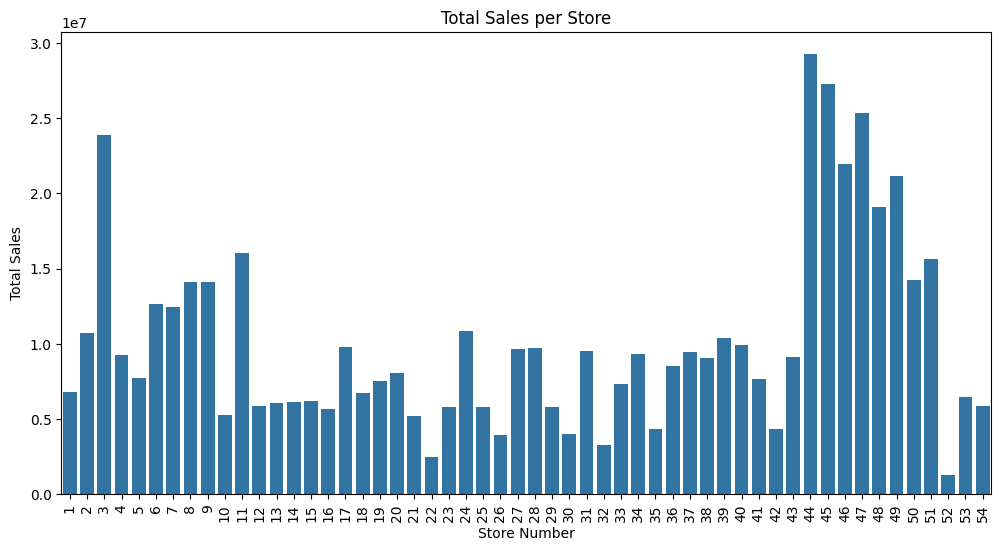

In [7]:
total_sales_per_store = df_train.groupby("store_nbr")["unit_sales"].sum()

# Plotting total sales per store
plt.figure(figsize=(12, 6))
sns.barplot(x=total_sales_per_store.index, y=total_sales_per_store.values)
plt.title("Total Sales per Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.xticks(rotation=90)
plt.show()
del total_sales_per_store

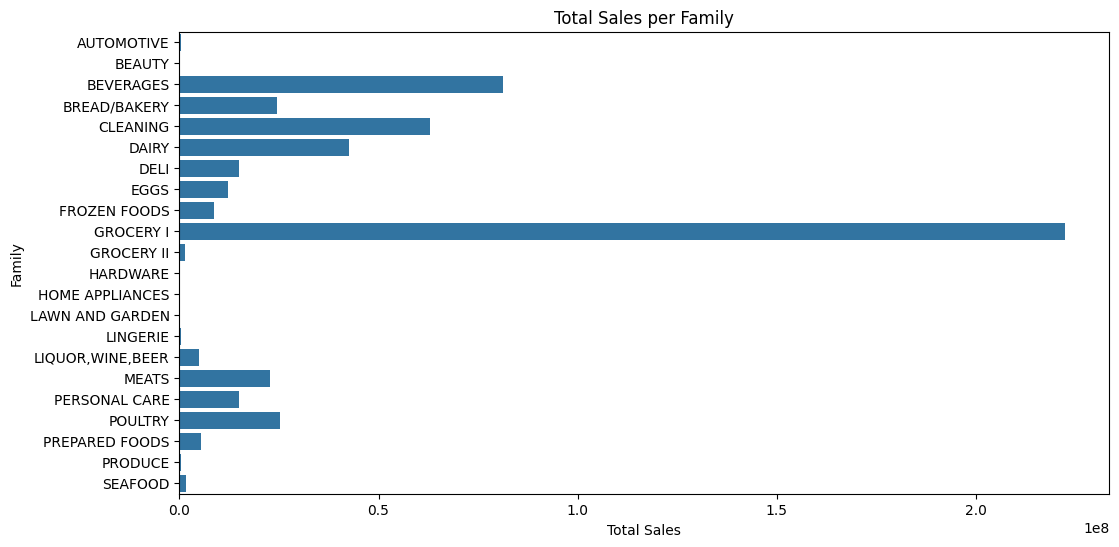

In [8]:
# Calculate total sales per family
total_sales_per_family = df_train.groupby("family")["unit_sales"].sum()

# Plotting total sales per family
plt.figure(figsize=(12, 6))
sns.barplot(x=total_sales_per_family.values,
            y=total_sales_per_family.index, orient='h')
plt.title("Total Sales per Family")
plt.xlabel("Total Sales")
plt.ylabel("Family")
plt.show()
del total_sales_per_family

/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


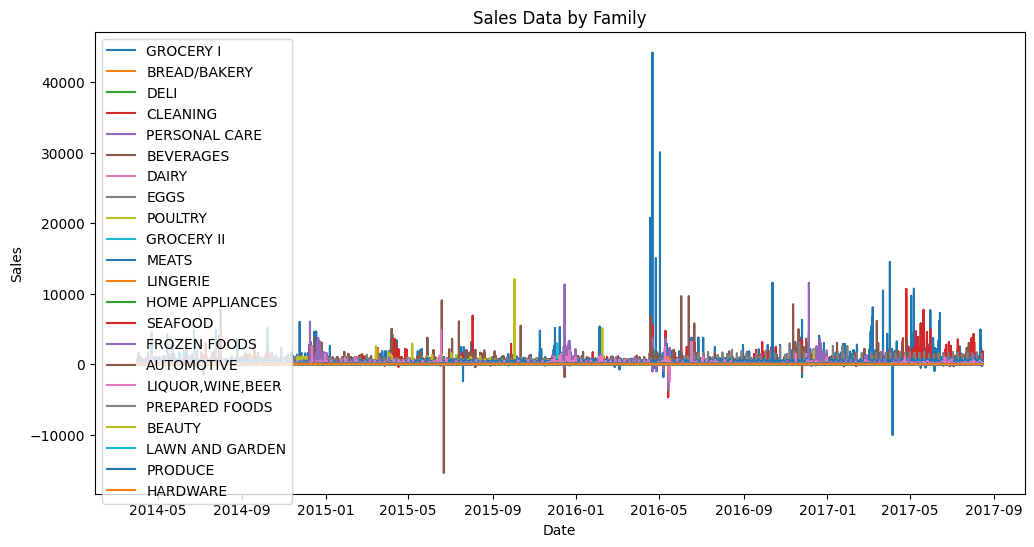

In [9]:
plt.figure(figsize=(12, 6))
for family in df_train['family'].unique():
    family_data = df_train[df_train['family'] == family]
    family_data.set_index('date', inplace=True)
    plt.plot(family_data.index, family_data['unit_sales'], label=family)
plt.legend()
plt.title('Sales Data by Family')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()
del family_data

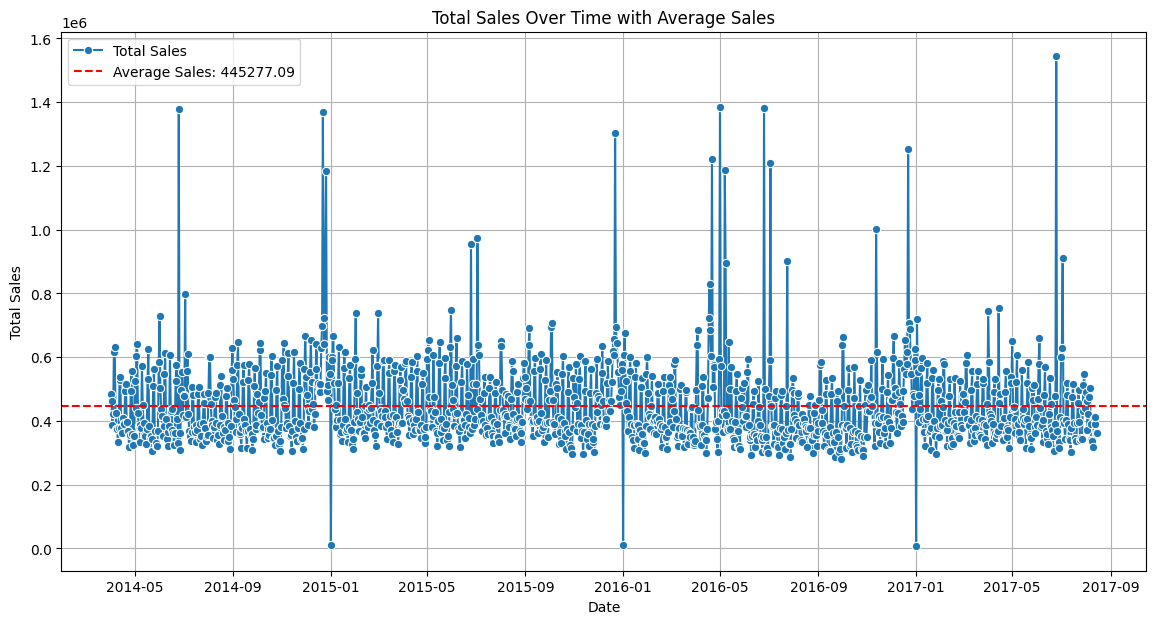

In [10]:
# Sales Over Time
plt.figure(figsize=(14, 7))

# Calculate total sales per date
sales_per_date = df_train.groupby('date')['unit_sales'].sum().reset_index()

# Calculate average sales
average_sales = sales_per_date['unit_sales'].mean()

# Plot total sales over time
sns.lineplot(x='date', y='unit_sales', data=sales_per_date,
             marker='o', label='Total Sales')

# Plot average sales as a horizontal line
plt.axhline(average_sales, color='red', linestyle='--',
            label=f'Average Sales: {average_sales:.2f}')

plt.title('Total Sales Over Time with Average Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.show()

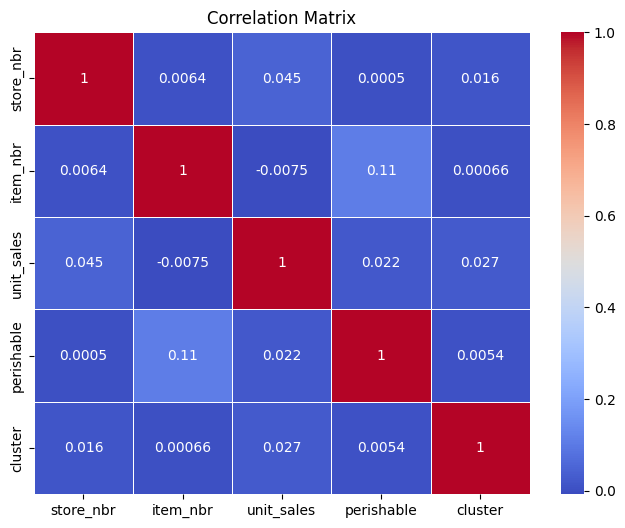

In [11]:
num_train = df_train.select_dtypes(
    include=['integer', 'float64'])

# Correlation Matrix
plt.figure(figsize=(8, 6))
corr_matrix = num_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [12]:
df_train.columns

Index(['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'family',
       'perishable', 'type_store', 'cluster', 'type_holiday', 'transferred'],
      dtype='object')

In [13]:
df_train_ = df_train[(df_train['date'] >= '2016-01-01') & (df_train['date'] <= '2017-12-31')].reset_index(drop=True)

In [14]:
df_train_ = df_train_[['date', 'store_nbr', 'unit_sales', 'family']]

In [15]:
# df_train_.to_csv("data/train_split.csv", index=False)

In [16]:
# Root data folder
data_folder = 'data/'
df_train = pd.read_csv(data_folder+'train_split.csv')

In [17]:
df_train["date"] = pd.to_datetime(df_train.date, cache=True)

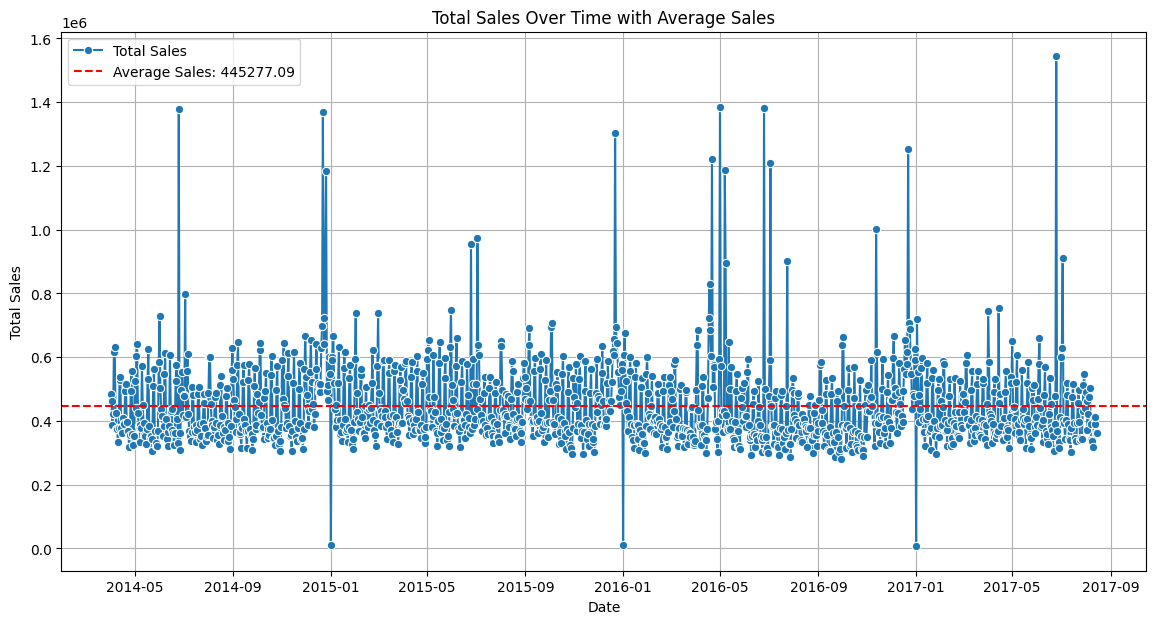

In [18]:
# Sales Over Time
plt.figure(figsize=(14, 7))

# Calculate total sales per date
sales_per_date = df_train.groupby('date')['unit_sales'].sum().reset_index()

# Calculate average sales
average_sales = sales_per_date['unit_sales'].mean()

# Plot total sales over time
sns.lineplot(x='date', y='unit_sales', data=sales_per_date,
             marker='o', label='Total Sales')

# Plot average sales as a horizontal line
plt.axhline(average_sales, color='red', linestyle='--',
            label=f'Average Sales: {average_sales:.2f}')

plt.title('Total Sales Over Time with Average Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.show()

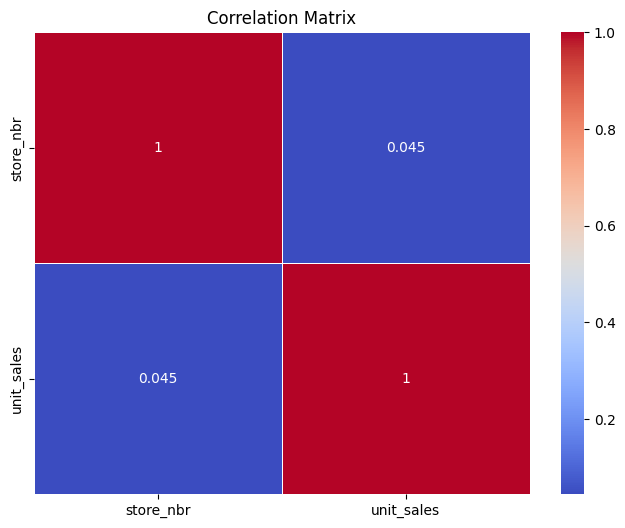

In [19]:
num_train = df_train.select_dtypes(
    include=['integer', 'float64'])

# Correlation Matrix
plt.figure(figsize=(8, 6))
corr_matrix = num_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [20]:
X = df_train.drop('unit_sales', axis=1)
y = df_train['unit_sales']

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(
        dtype_include=['int64', 'float64'])),
    ('cat', cat_pipeline, make_column_selector(dtype_include='object'))
])

X_prepared = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((54738043, 23), (13684511, 23), (54738043,), (13684511,))

In [21]:
X_train_df = pd.DataFrame(
    X_train.toarray(), columns=preprocessor.get_feature_names_out())
X_train_df.head(2)

num__store_nbr  cat__family_AUTOMOTIVE  cat__family_BEAUTY  \
0        1.321765                     0.0                 0.0   
1       -0.030312                     0.0                 0.0   

   cat__family_BEVERAGES  cat__family_BREAD/BAKERY  cat__family_CLEANING  \
0                    0.0                       0.0                   0.0   
1                    0.0                       0.0                   0.0   

   cat__family_DAIRY  cat__family_DELI  cat__family_EGGS  \
0                0.0               0.0               0.0   
1                0.0               0.0               0.0   

   cat__family_FROZEN FOODS  ...  cat__family_HOME APPLIANCES  \
0                       0.0  ...                          0.0   
1                       0.0  ...                          0.0   

   cat__family_LAWN AND GARDEN  cat__family_LINGERIE  \
0                          0.0                   0.0   
1                          0.0                   0.0   

   cat__family_LIQUOR,WINE,BEER  cat__family_MEATS  cat__family_PERSONAL CARE  \
0                           0.0                0.0                        0.0   
1                           0.0                0.0                        1.0   

   cat__family_POULTRY  cat__family_PREPARED FOODS  cat__family_PRODUCE  \
0                  0.0                         0.0                  0.0   
1                  0.0                         0.0                  0.0   

   cat__family_SEAFOOD  
0                  0.0  
1                  0.0  

[2 rows x 23 columns]

In [22]:
sales_per_date = df_train.groupby('date')['unit_sales'].sum().reset_index()
sales_per_date['Time'] = np.arange(len(sales_per_date.index))
sales_per_date.head(2)

date  unit_sales  Time
0 2014-04-01  485078.887     0
1 2014-04-02  463832.908     1

In [23]:
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

%config InlineBackend.figure_format = 'retina'

Text(0.5, 1.0, 'Time Plot of Sales')

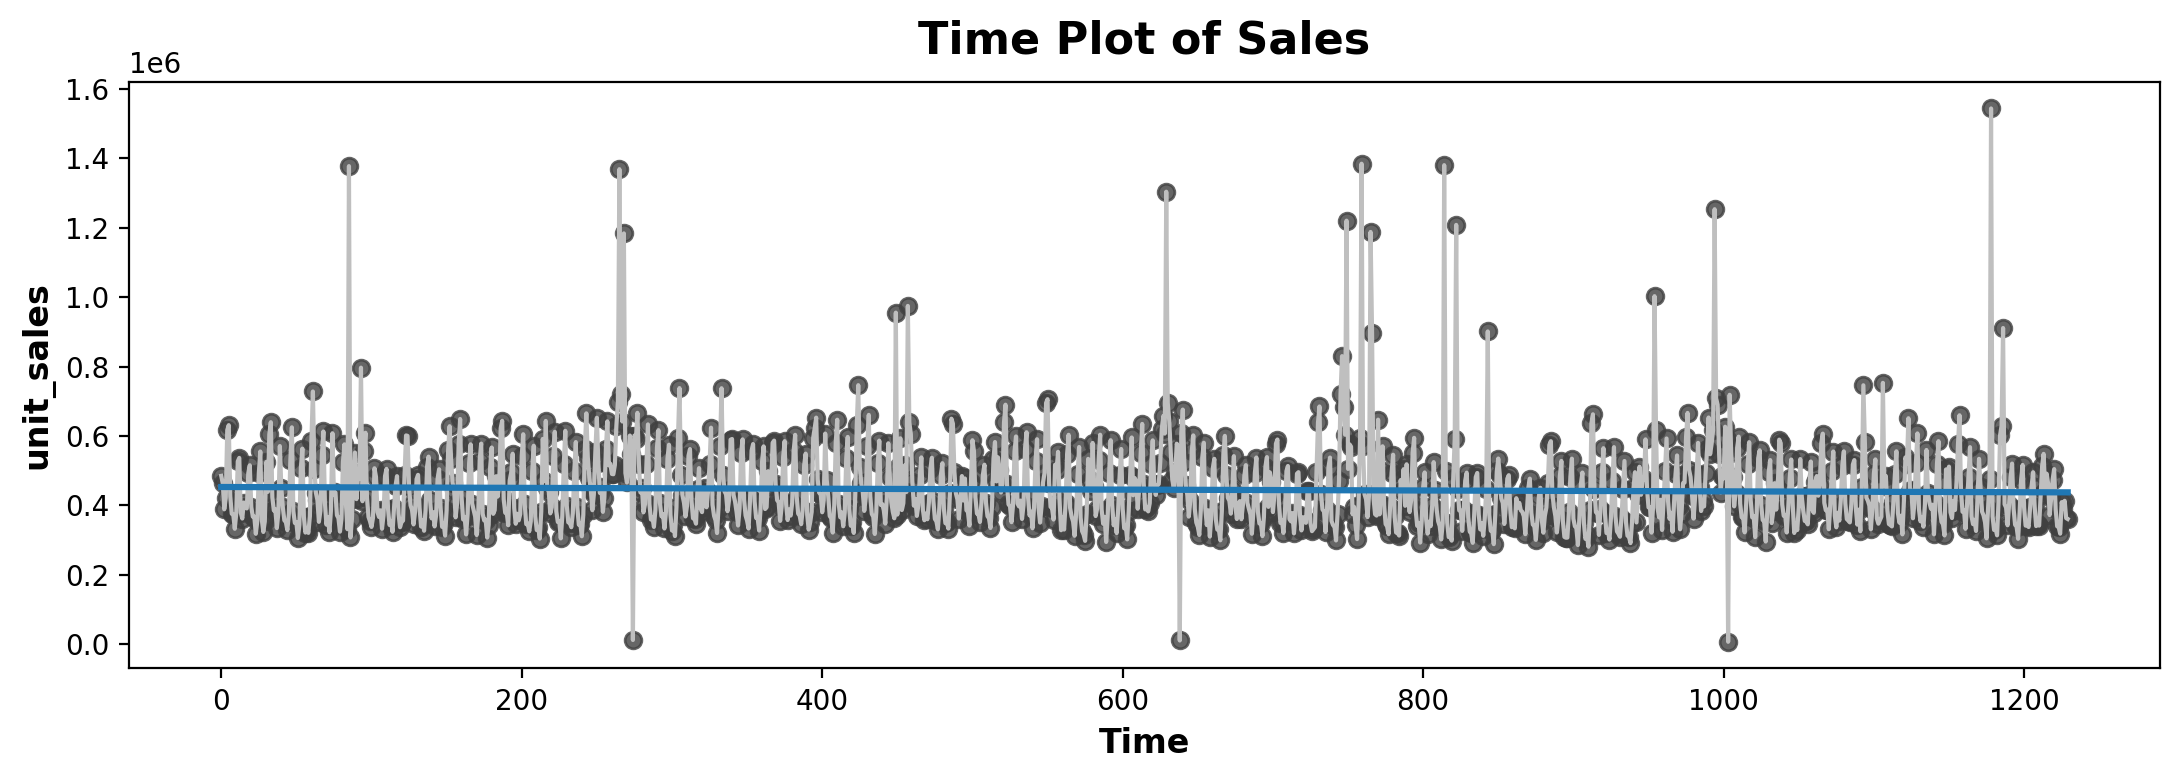

In [24]:
fig, ax = plt.subplots()
ax.plot('Time', 'unit_sales', data=sales_per_date, color='0.75')
ax = sns.regplot(x='Time', y='unit_sales', data=sales_per_date, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Sales')

## Lag features

In [24]:
sales_per_date['sales_lag1'] = sales_per_date['unit_sales'].shift(1)
sales_per_date.head(2)

date  unit_sales  Time  sales_lag1
0 2014-04-01  485078.887     0         NaN
1 2014-04-02  463832.908     1  485078.887

Text(0.5, 1.0, 'Lag Plot of Sales')

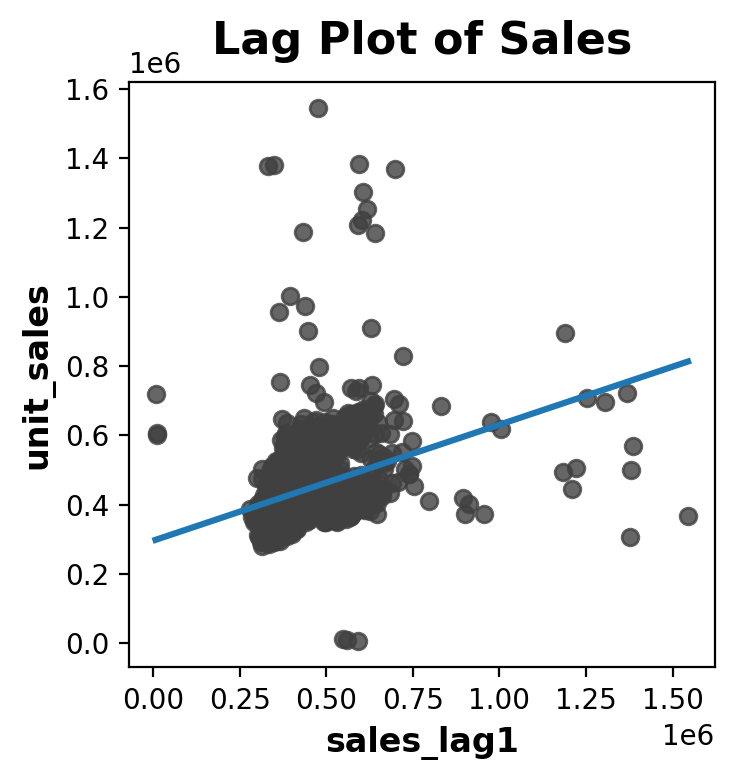

In [25]:
fig, ax = plt.subplots()
ax = sns.regplot(x='sales_lag1', y='unit_sales', data=sales_per_date,
                 ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Sales')

In [26]:
from sklearn.linear_model import LinearRegression

# Training data
X = sales_per_date.loc[:, ['Time']]  # features
y = sales_per_date.loc[:, 'unit_sales']  # target

lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [27]:
y_pred = pd.Series(lin_reg.predict(X), index=X.index)
lin_reg.coef_, lin_reg.intercept_

(array([-12.53950463]), np.float64(452982.61730785447))

Text(0.5, 1.0, 'Time Plot of sales')

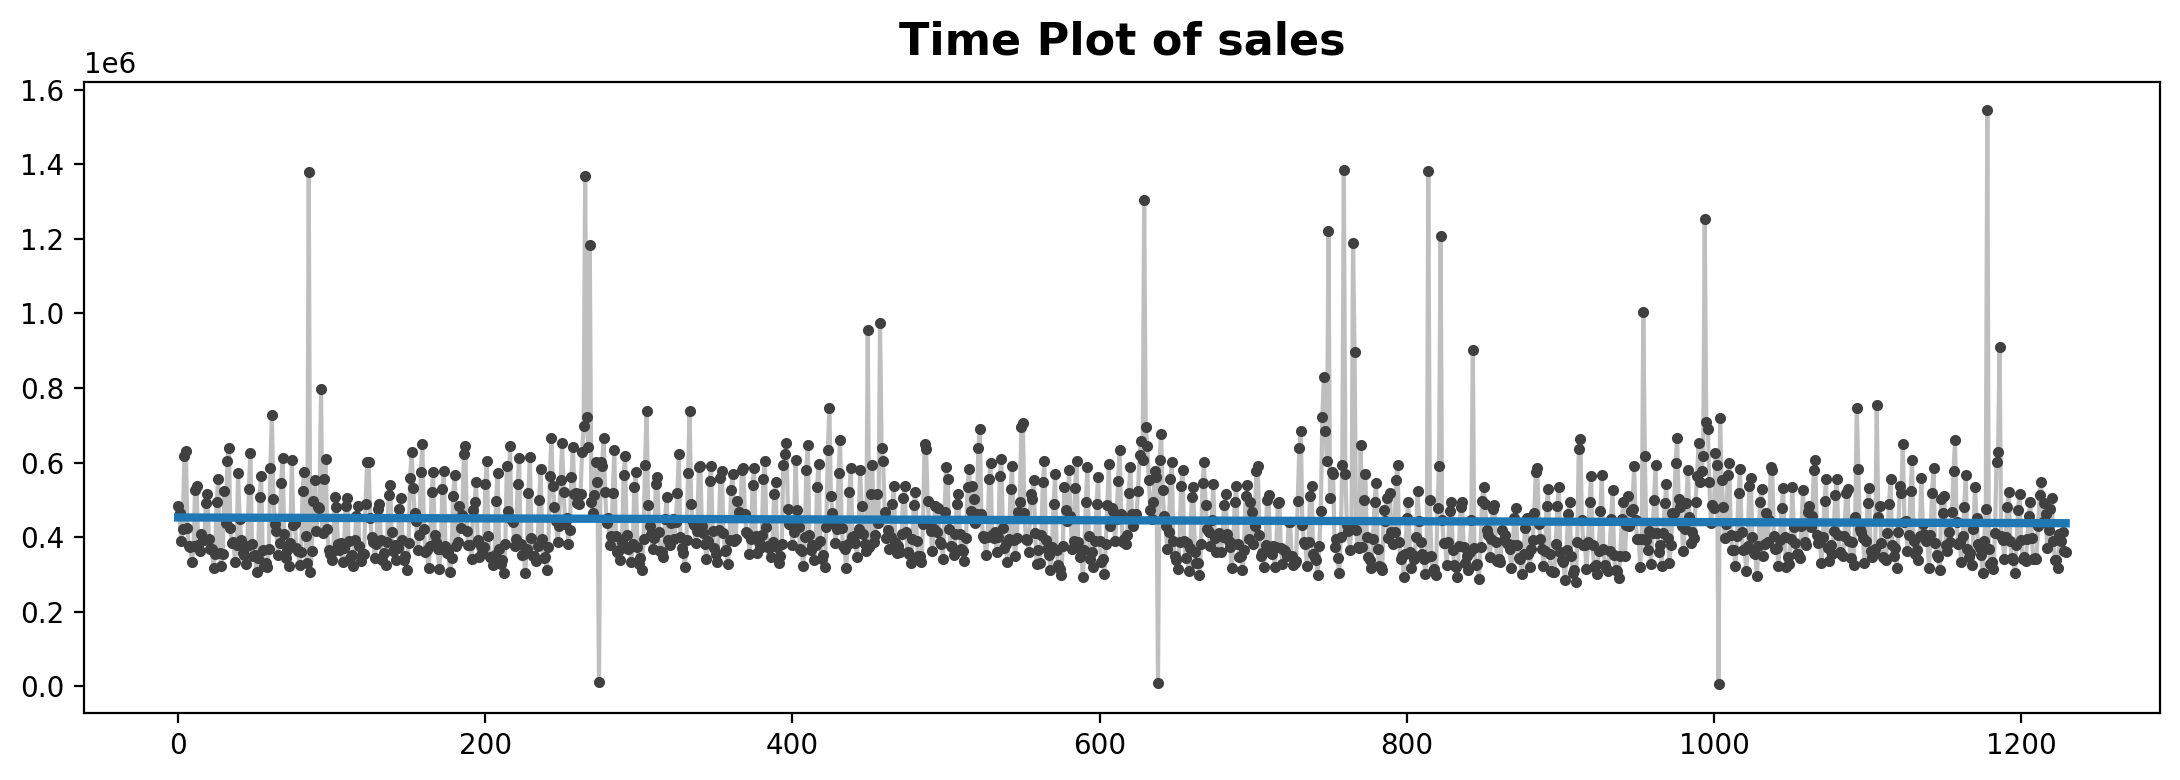

In [28]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of sales')

In [29]:
lin_metrics_time = regression_metrics_df(
    y, y_pred, y, y_pred, 'LinearRegression - time step features')
lin_metrics_time

Metric  Train Set   Test Set  \
0                        RMSE  133566.23  133566.23   
1                    MAPE (%)      31.40      31.40   
2                    R2 Score       0.00       0.00   
3                         MAE   92617.52   92617.52   
4  Relative Error to Mean (%)      30.00      30.00   

                                   Model  
0  LinearRegression - time step features  
1  LinearRegression - time step features  
2  LinearRegression - time step features  
3  LinearRegression - time step features  
4  LinearRegression - time step features

In [30]:
plot_residuals(y, y_pred, 'Residuals of LinearRegression - time step features')

Text(0.5, 1.0, 'Lag Plot of Sales')

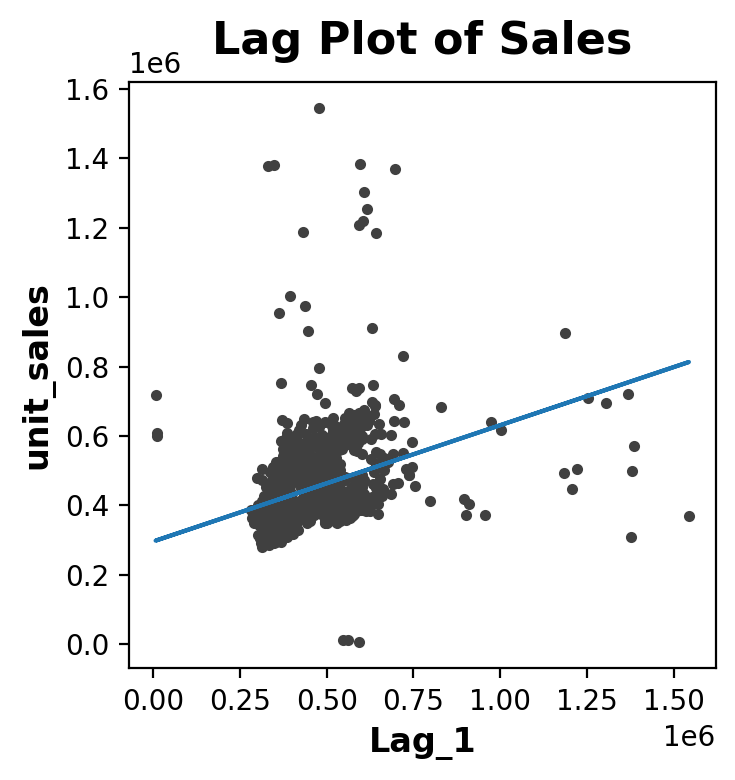

In [31]:
X = sales_per_date.loc[:, ['sales_lag1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = sales_per_date.loc[:, 'unit_sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots()
ax.plot(X['sales_lag1'], y, '.', color='0.25')
ax.plot(X['sales_lag1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('unit_sales')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Sales')

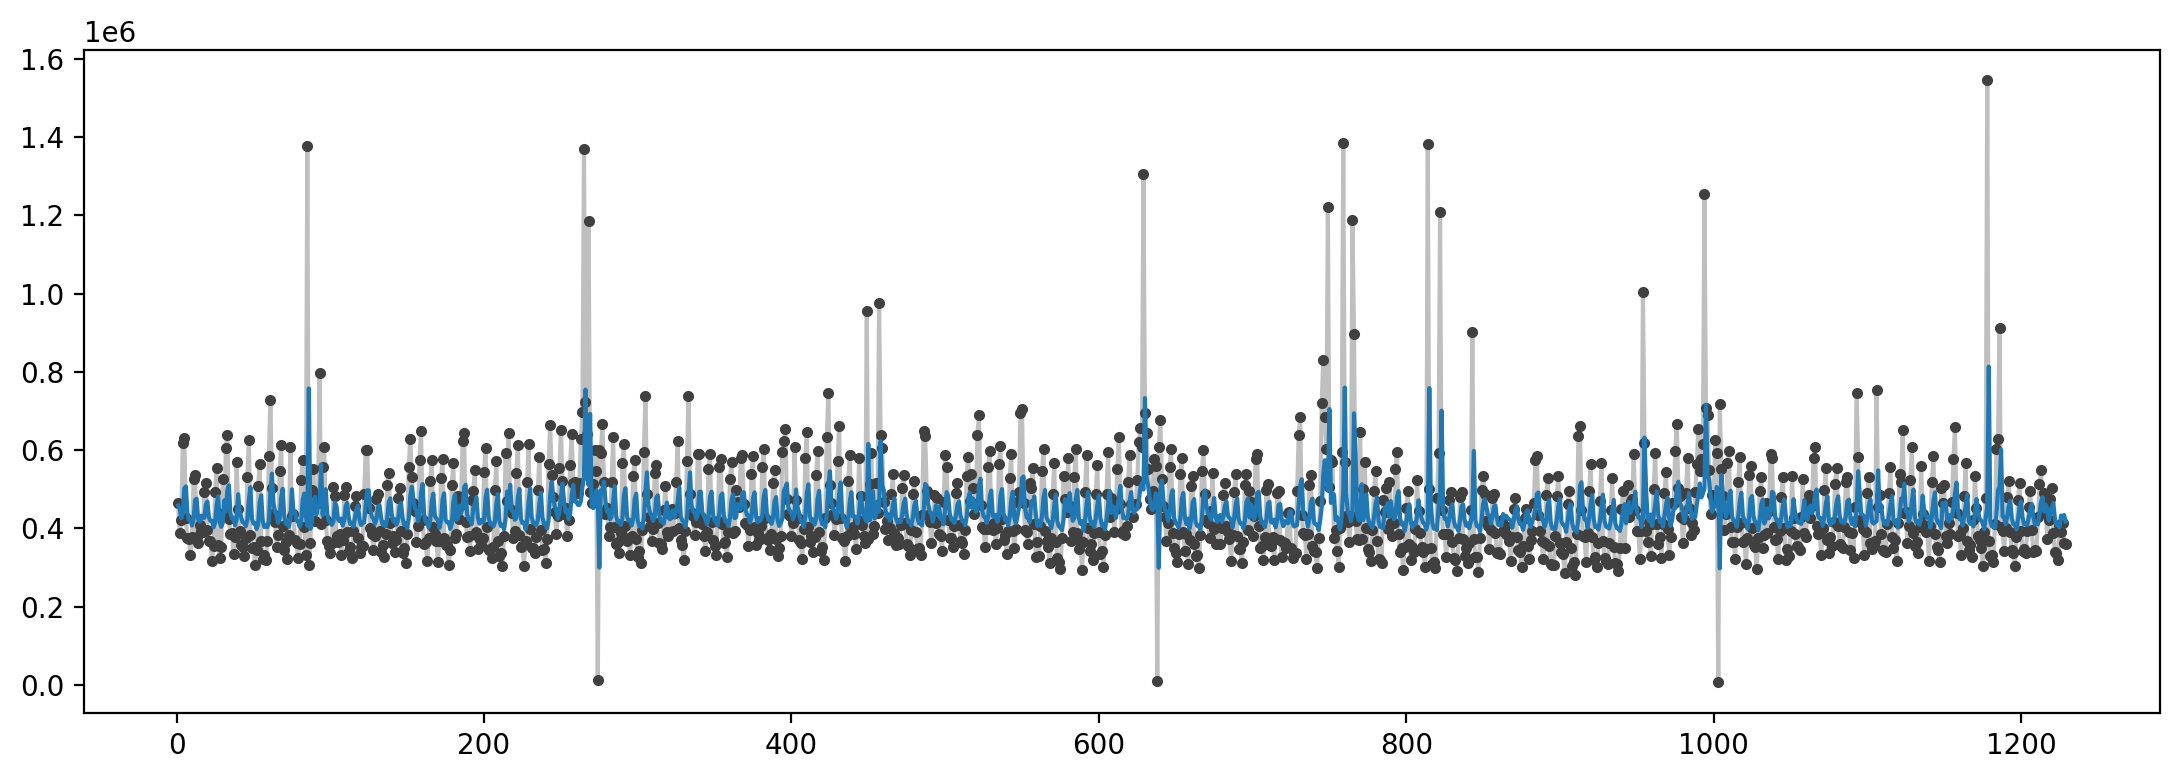

In [32]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

In [33]:
lin_metrics_time = regression_metrics_df(
    y, y_pred, y, y_pred, 'LinearRegression - time step features')
lin_metrics_time

Metric  Train Set   Test Set  \
0                        RMSE  125967.89  125967.89   
1                    MAPE (%)      30.30      30.30   
2                    R2 Score       0.11       0.11   
3                         MAE   83676.50   83676.50   
4  Relative Error to Mean (%)      28.30      28.30   

                                   Model  
0  LinearRegression - time step features  
1  LinearRegression - time step features  
2  LinearRegression - time step features  
3  LinearRegression - time step features  
4  LinearRegression - time step features

# SGDRegressor

In [34]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(random_state=42)
%time sgd_reg.fit(X_train, y_train)

y_train_pred = sgd_reg.predict(X_train)
y_test_pred = sgd_reg.predict(X_test)

sgd_metrics = regression_metrics_df(y_train, y_train_pred, y_test, y_test_pred, 'SGDRegressor')
sgd_metrics

CPU times: user 3min 15s, sys: 467 ms, total: 3min 16s
Wall time: 3min 17s


Metric  Train Set  Test Set         Model
0                        RMSE      21.98     18.58  SGDRegressor
1                    MAPE (%)     222.80    222.70  SGDRegressor
2                    R2 Score       0.01      0.02  SGDRegressor
3                         MAE       7.02      7.01  SGDRegressor
4  Relative Error to Mean (%)     274.50    232.30  SGDRegressor

/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



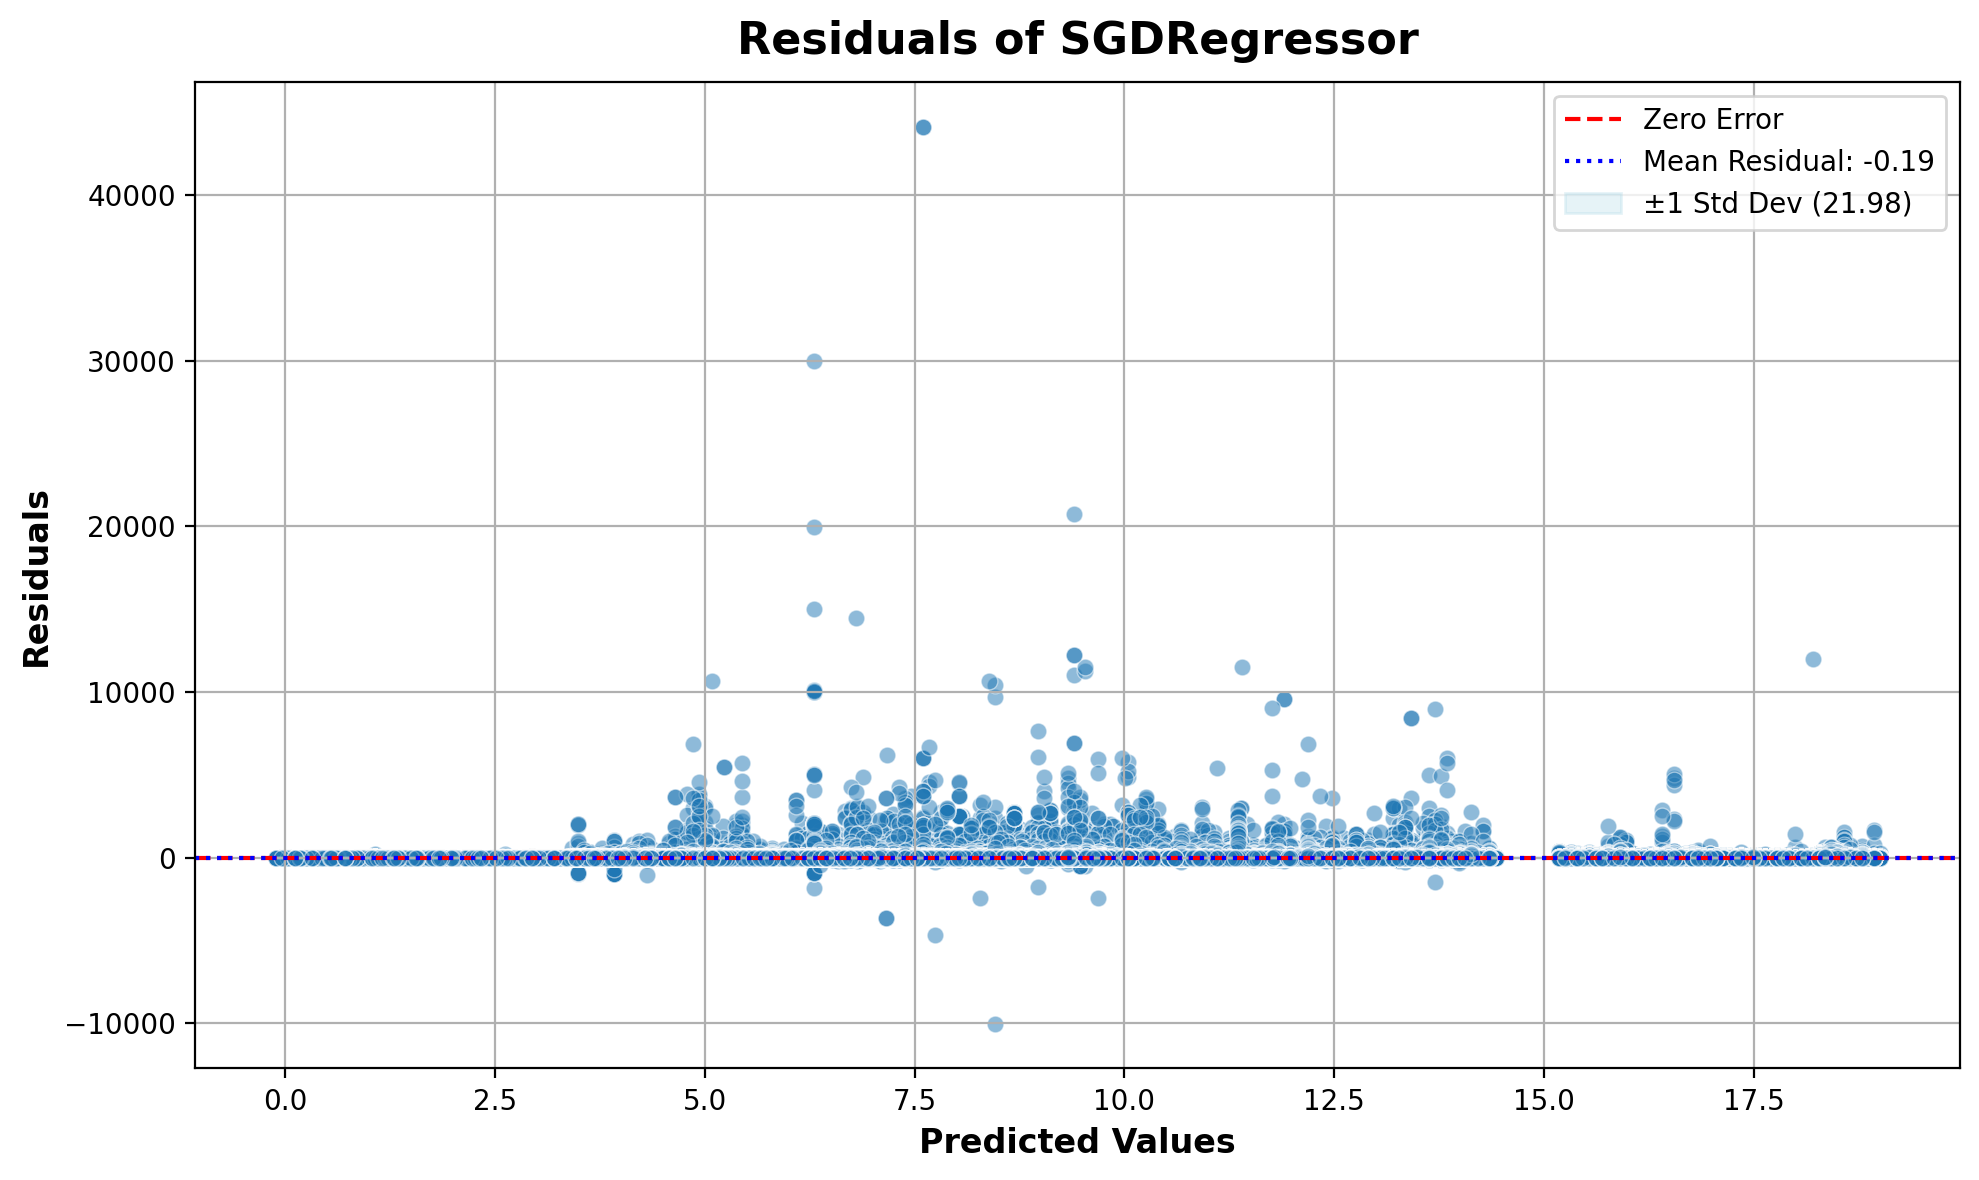

In [35]:
plot_residuals_sns(y_train, y_train_pred, 'Residuals of SGDRegressor')

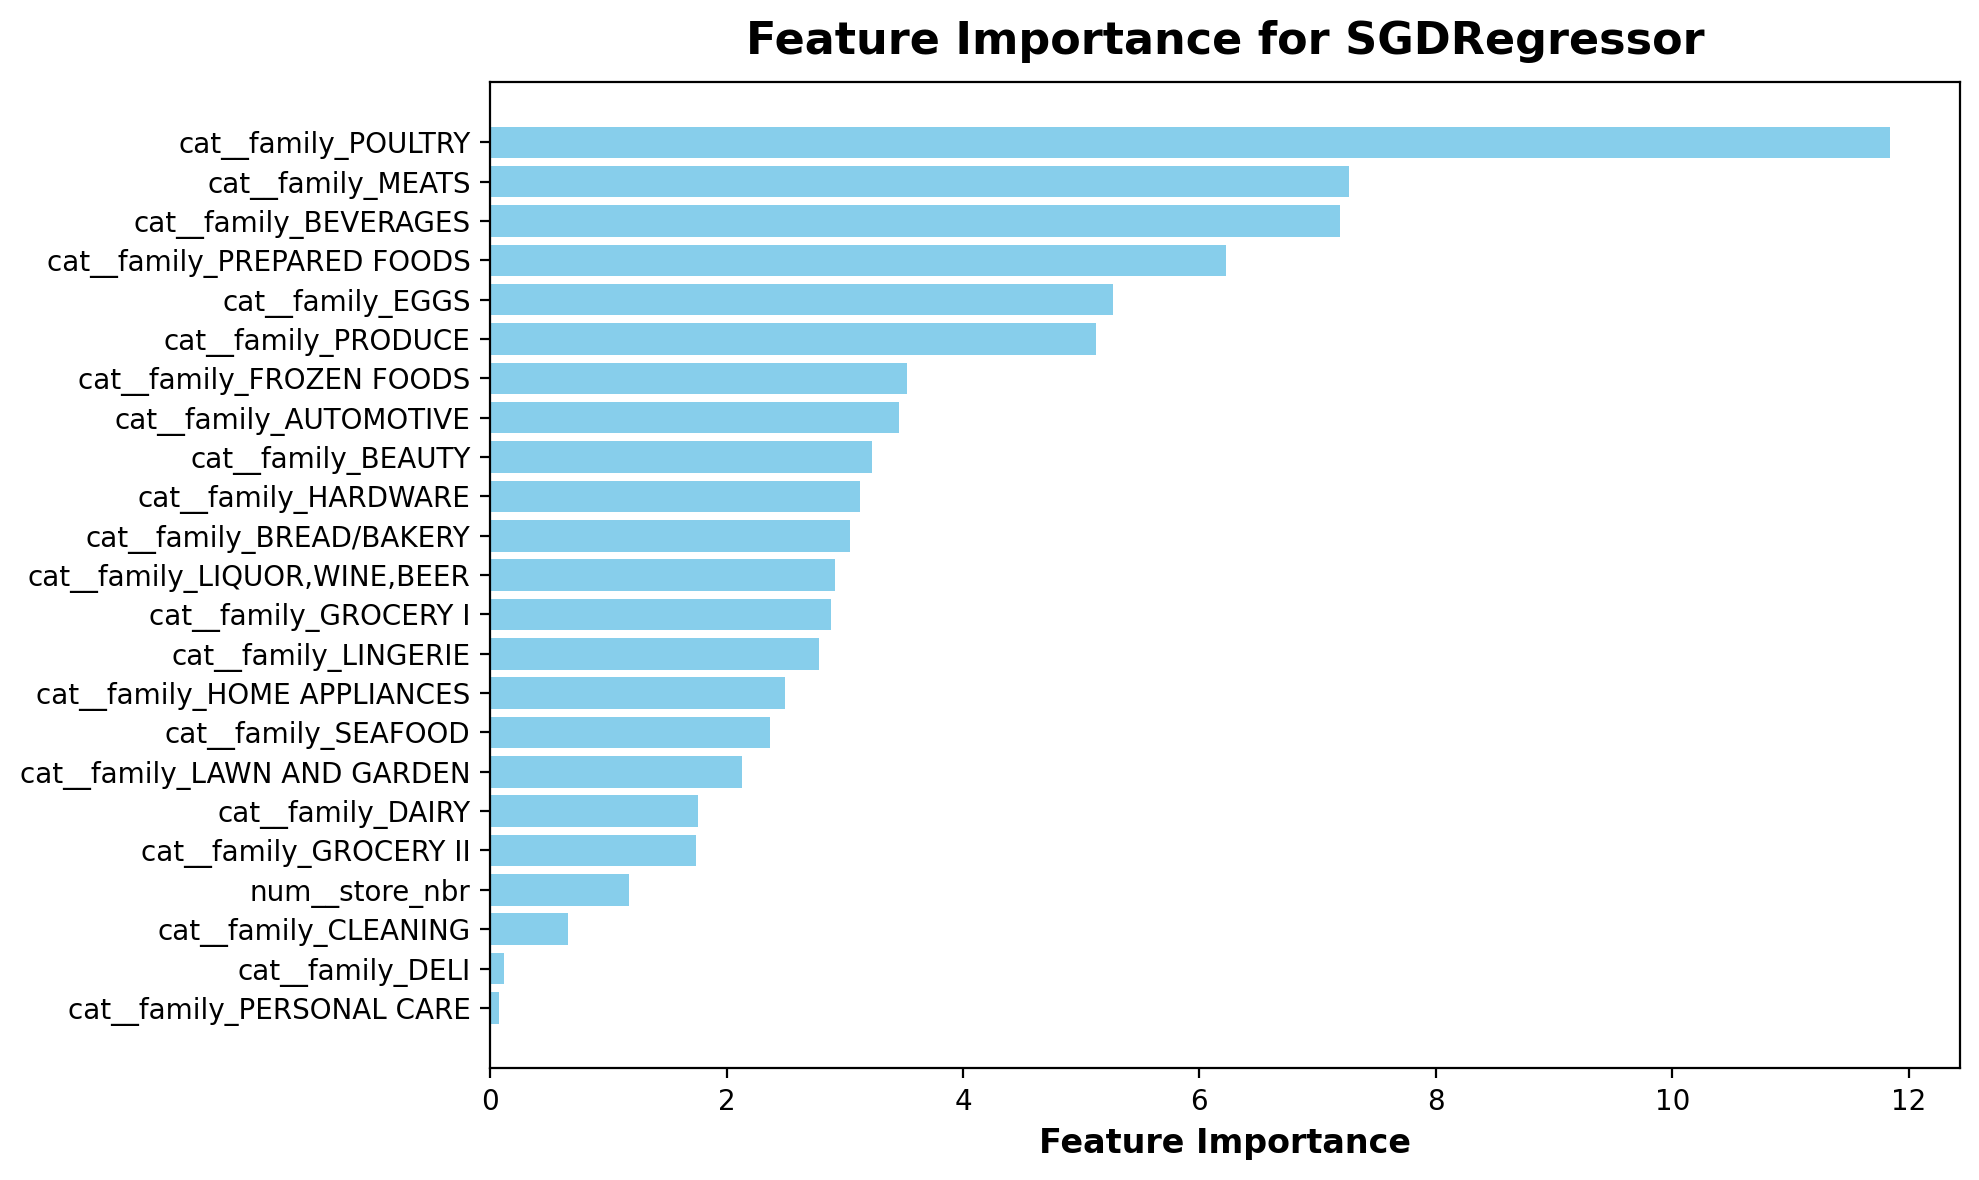

In [36]:
# Get feature importance (absolute values of coefficients)
feature_importance = np.abs(sgd_reg.coef_)
# Get the feature names
feature_names = preprocessor.get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
sorted_importance = feature_importance[sorted_idx]
sorted_features = np.array(feature_names)[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for SGDRegressor')
plt.show()

In [37]:
lin_reg = LinearRegression()

%time lin_reg.fit(X_train, y_train)

CPU times: user 49.4 s, sys: 10.9 s, total: 1min
Wall time: 32.4 s


LinearRegression()

In [38]:
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

In [39]:
lin_metrics = regression_metrics_df(
    y_train, y_train_pred, y_test, y_test_pred, 'LinearRegression')
lin_metrics

Metric  Train Set  Test Set             Model
0                        RMSE      21.98     18.57  LinearRegression
1                    MAPE (%)     216.30    216.20  LinearRegression
2                    R2 Score       0.01      0.02  LinearRegression
3                         MAE       6.92      6.91  LinearRegression
4  Relative Error to Mean (%)     274.50    232.20  LinearRegression

/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



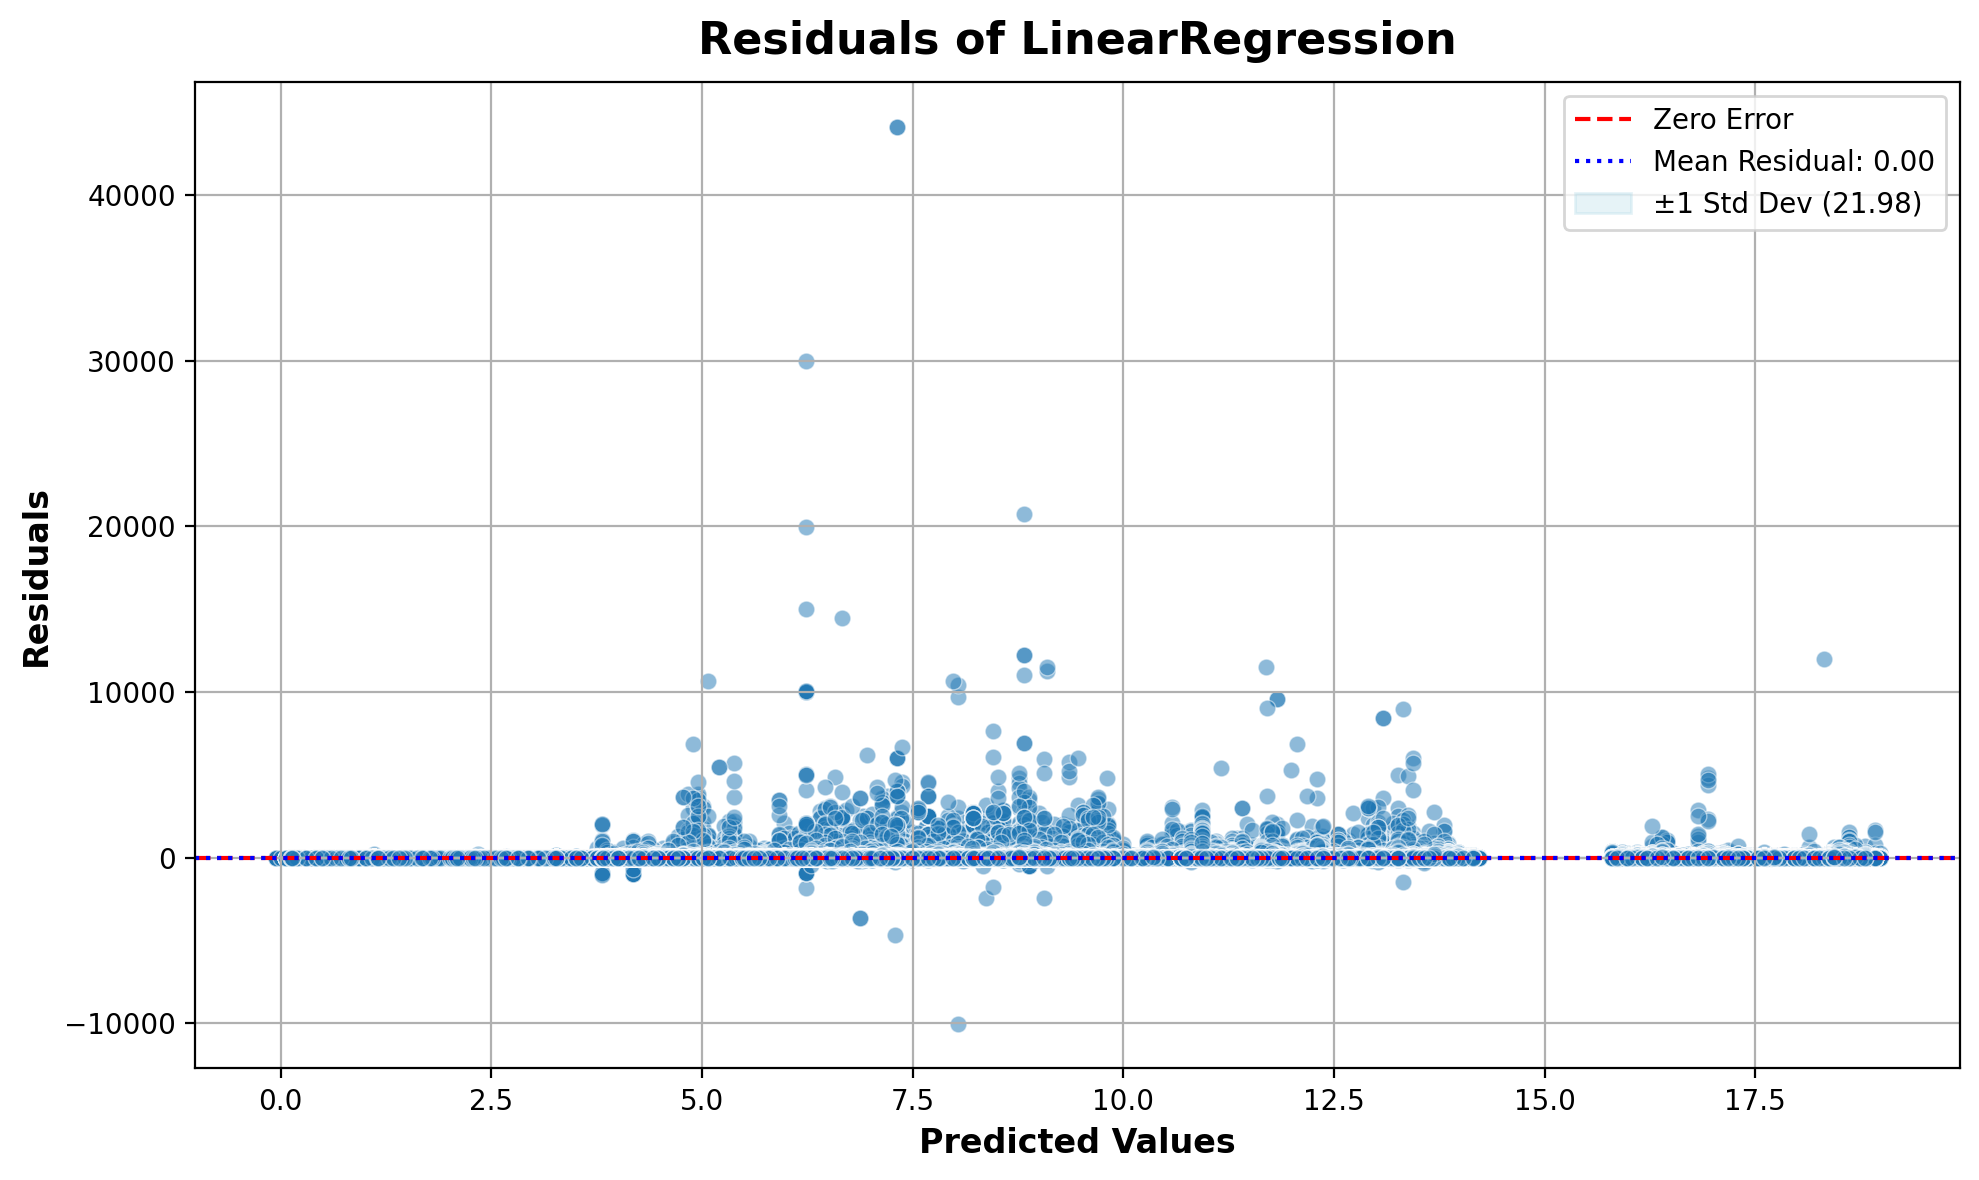

In [40]:
plot_residuals_sns(y_train, y_train_pred, 'Residuals of LinearRegression')

## Trend

In [41]:
sales_per_date = df_train.groupby('date')['unit_sales'].sum().reset_index()
sales_per_date = sales_per_date.set_index('date')
sales_per_date.head(2)

unit_sales
date                  
2014-04-01  485078.887
2014-04-02  463832.908

<Axes: title={'center': 'Sales - 365-Day Moving Average'}, xlabel='date'>

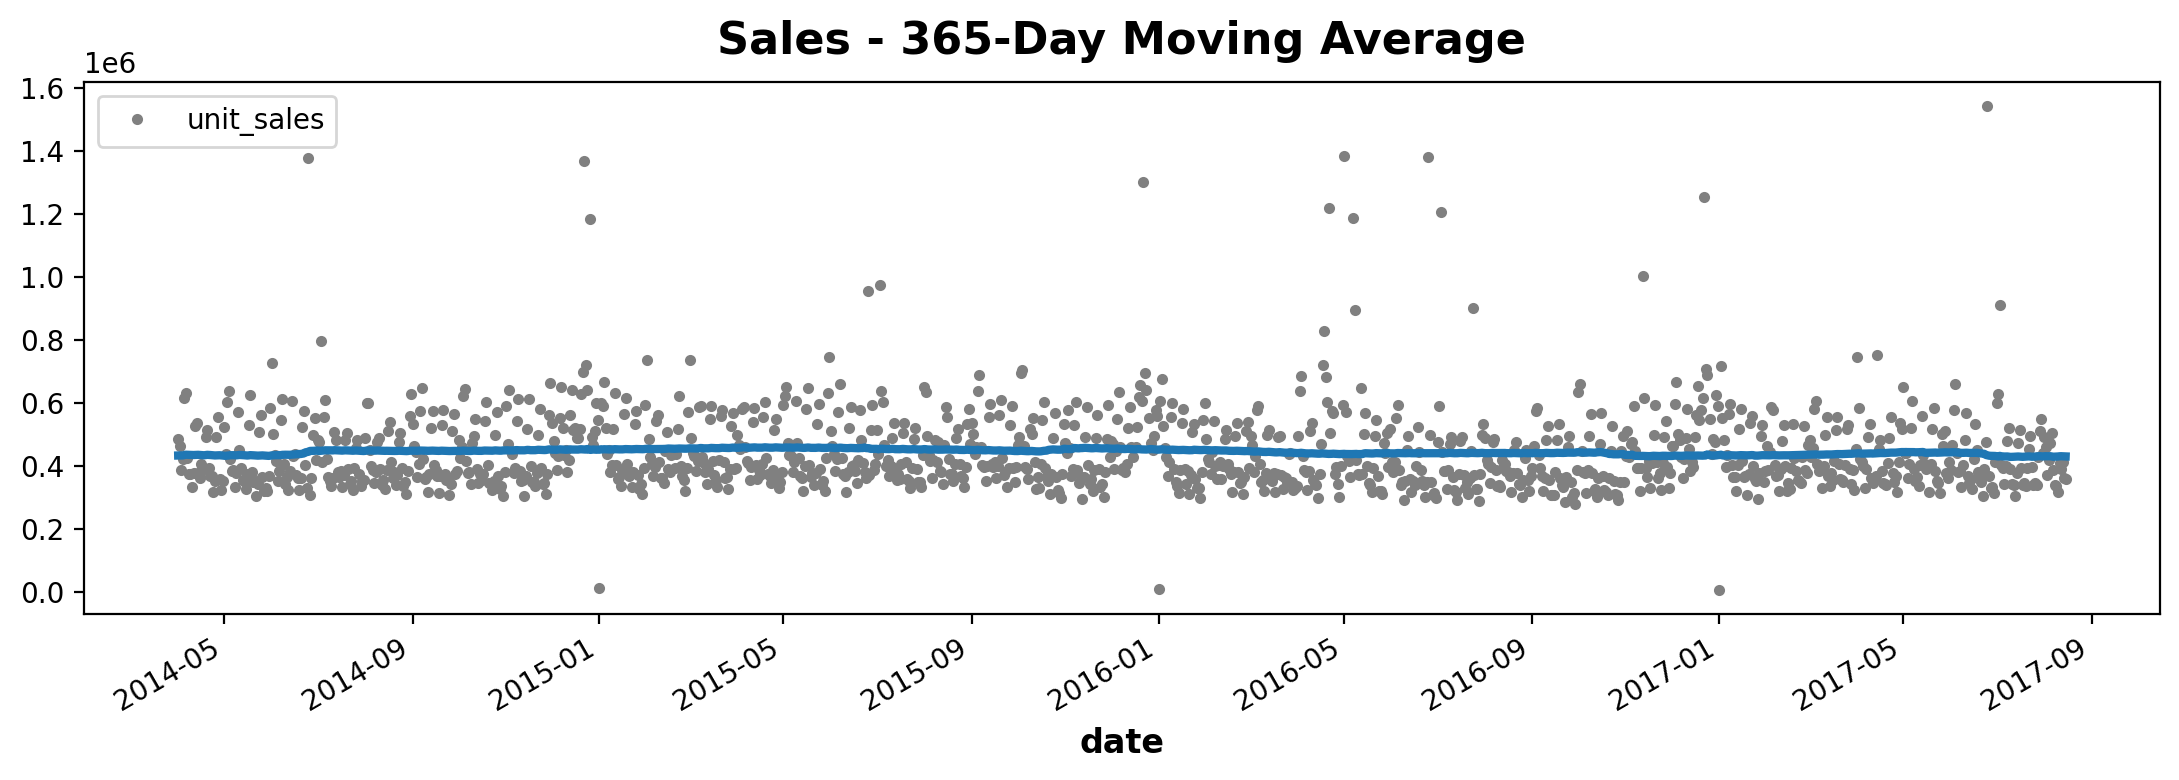

In [42]:
moving_average = sales_per_date.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = sales_per_date.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Sales - 365-Day Moving Average", legend=False,
)

<Axes: title={'center': 'Sales - 30-Day Moving Average'}, xlabel='date'>

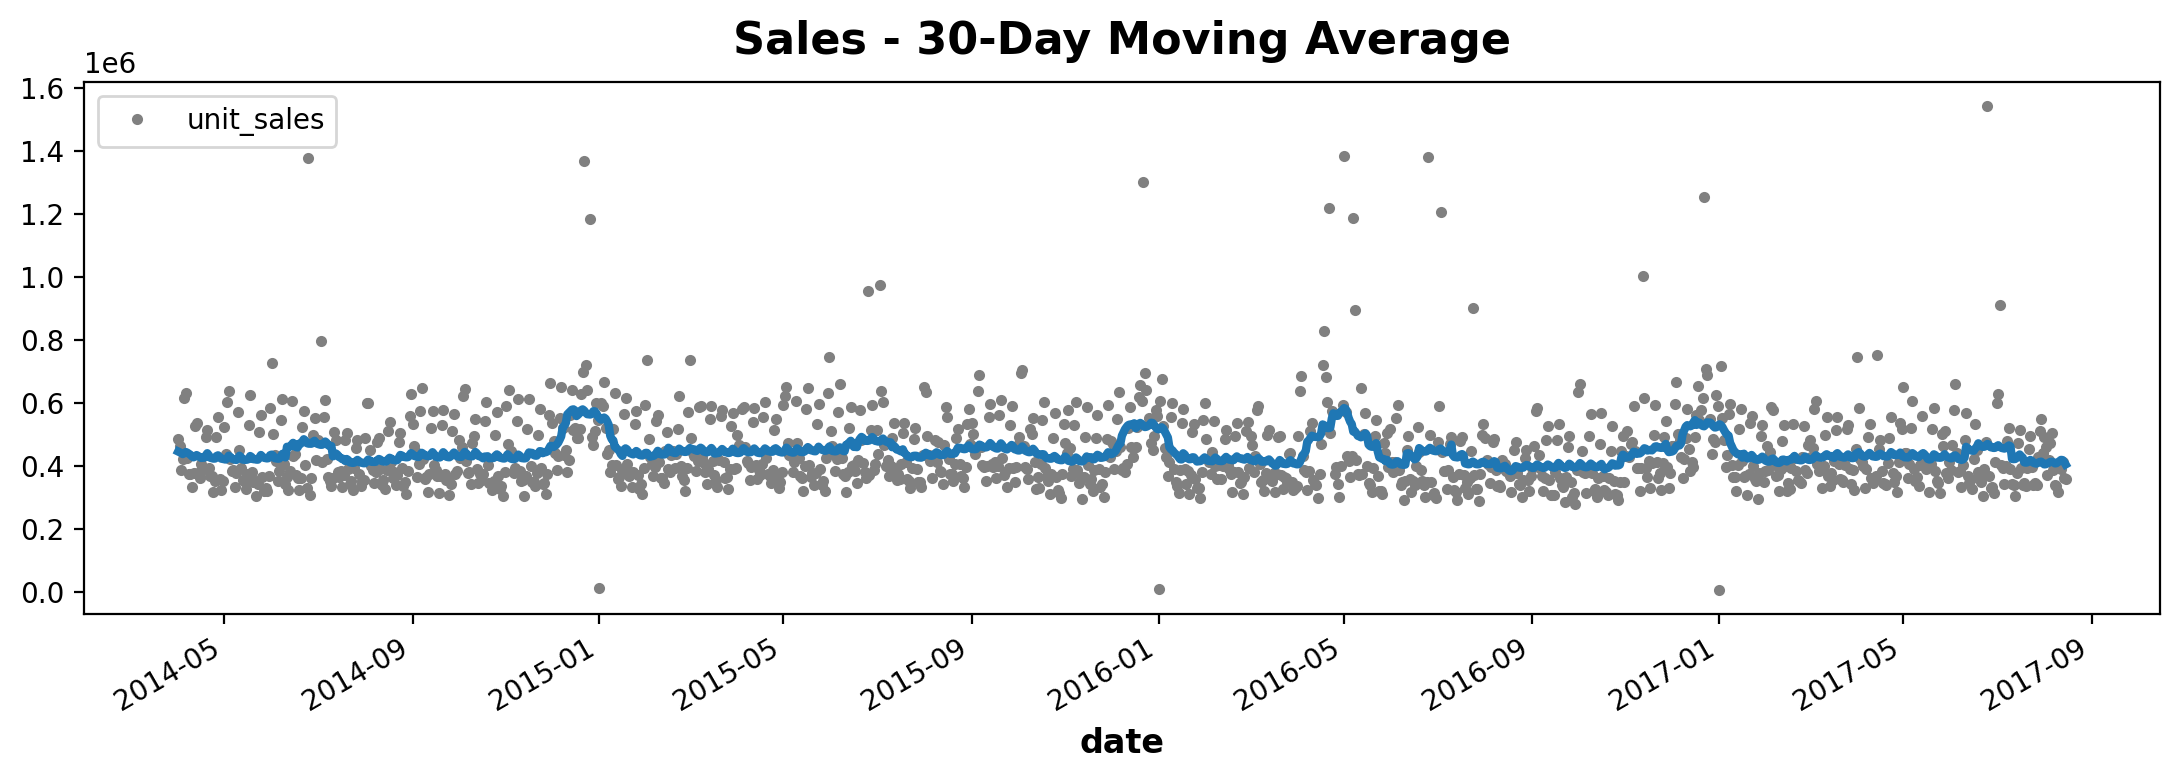

In [43]:
moving_average = sales_per_date.rolling(
    window=30,       # 30-day window
    center=True,      # puts the average at the center of the window
    min_periods=15,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = sales_per_date.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Sales - 30-Day Moving Average", legend=False,
)

In [44]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=sales_per_date.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

In [45]:
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

const  trend
date                    
2014-04-01    1.0    1.0
2014-04-02    1.0    2.0
2014-04-03    1.0    3.0
2014-04-04    1.0    4.0
2014-04-05    1.0    5.0

In [46]:
from sklearn.linear_model import LinearRegression

y = sales_per_date['unit_sales']  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [47]:
y_pred = pd.Series(model.predict(X), index=X.index)
regression_metrics_df(y, y_pred, y, y_pred, 'LinearRegression - trend')

Metric  Train Set   Test Set                     Model
0                        RMSE  133566.23  133566.23  LinearRegression - trend
1                    MAPE (%)      31.40      31.40  LinearRegression - trend
2                    R2 Score       0.00       0.00  LinearRegression - trend
3                         MAE   92617.52   92617.52  LinearRegression - trend
4  Relative Error to Mean (%)      30.00      30.00  LinearRegression - trend

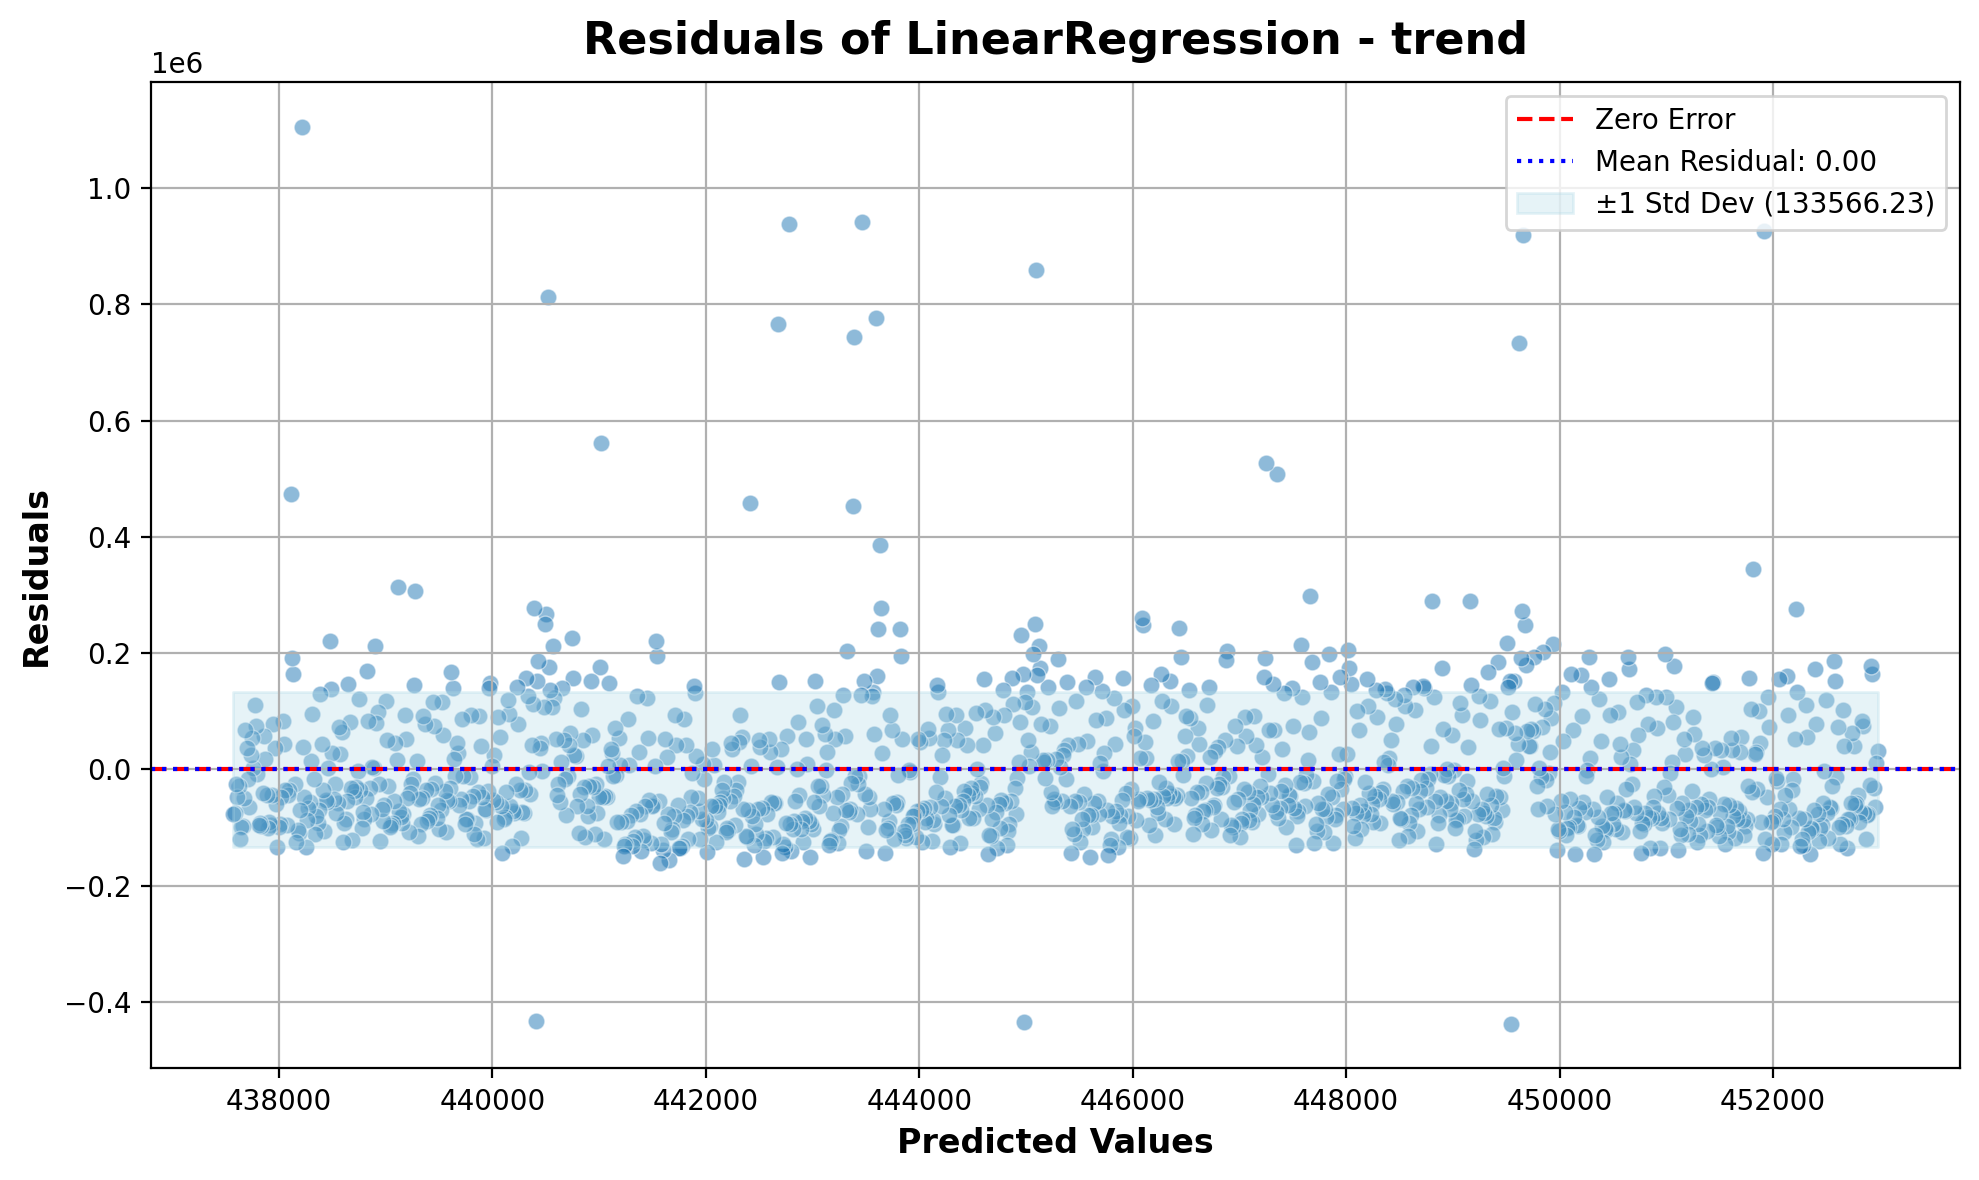

In [48]:
plot_residuals_sns(y, y_pred, 'Residuals of LinearRegression - trend')

The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

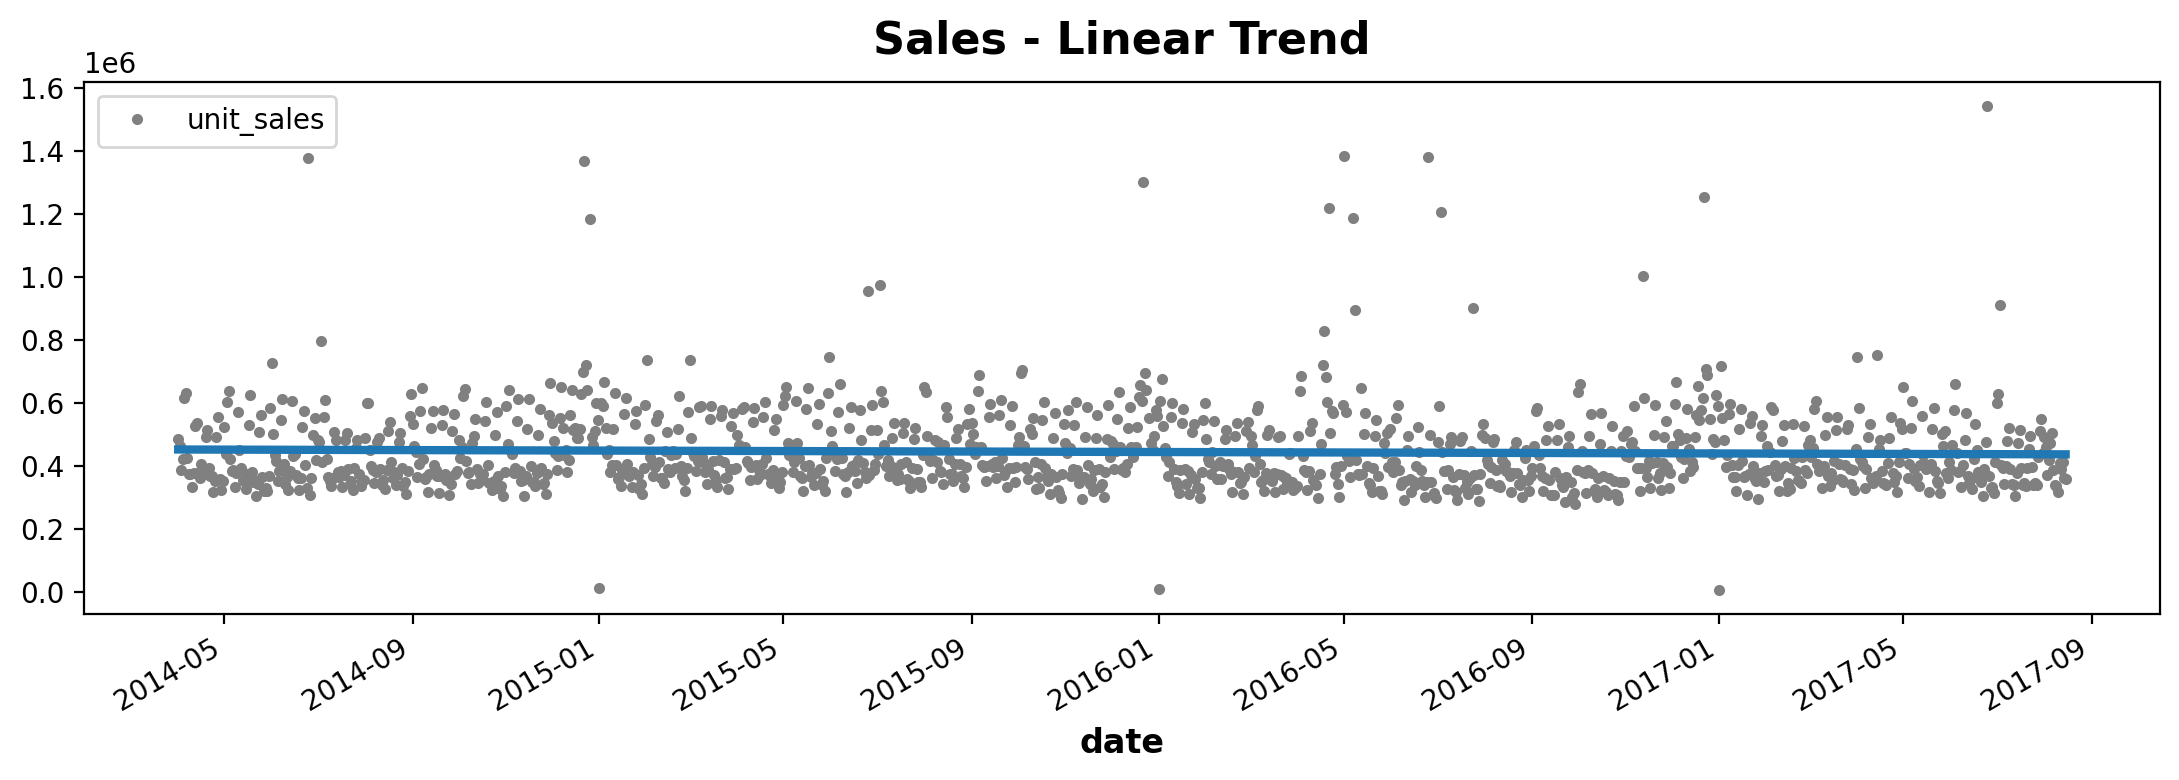

In [49]:
ax = sales_per_date.plot(style=".", color="0.5", title="Sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [50]:
# Create the out-of-sample feature DataFrame
out_of_sample_df = dp.out_of_sample(steps=30)

# Generate a date range for the forecast period
start_date = X.index[-1] + pd.Timedelta(days=1)
date_range = pd.date_range(start=start_date, periods=30, freq='D')

# Assign this date range to the index of the out-of-sample DataFrame
out_of_sample_df.index = date_range
out_of_sample_df.head()

/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



const   trend
2017-08-16    1.0  1231.0
2017-08-17    1.0  1232.0
2017-08-18    1.0  1233.0
2017-08-19    1.0  1234.0
2017-08-20    1.0  1235.0

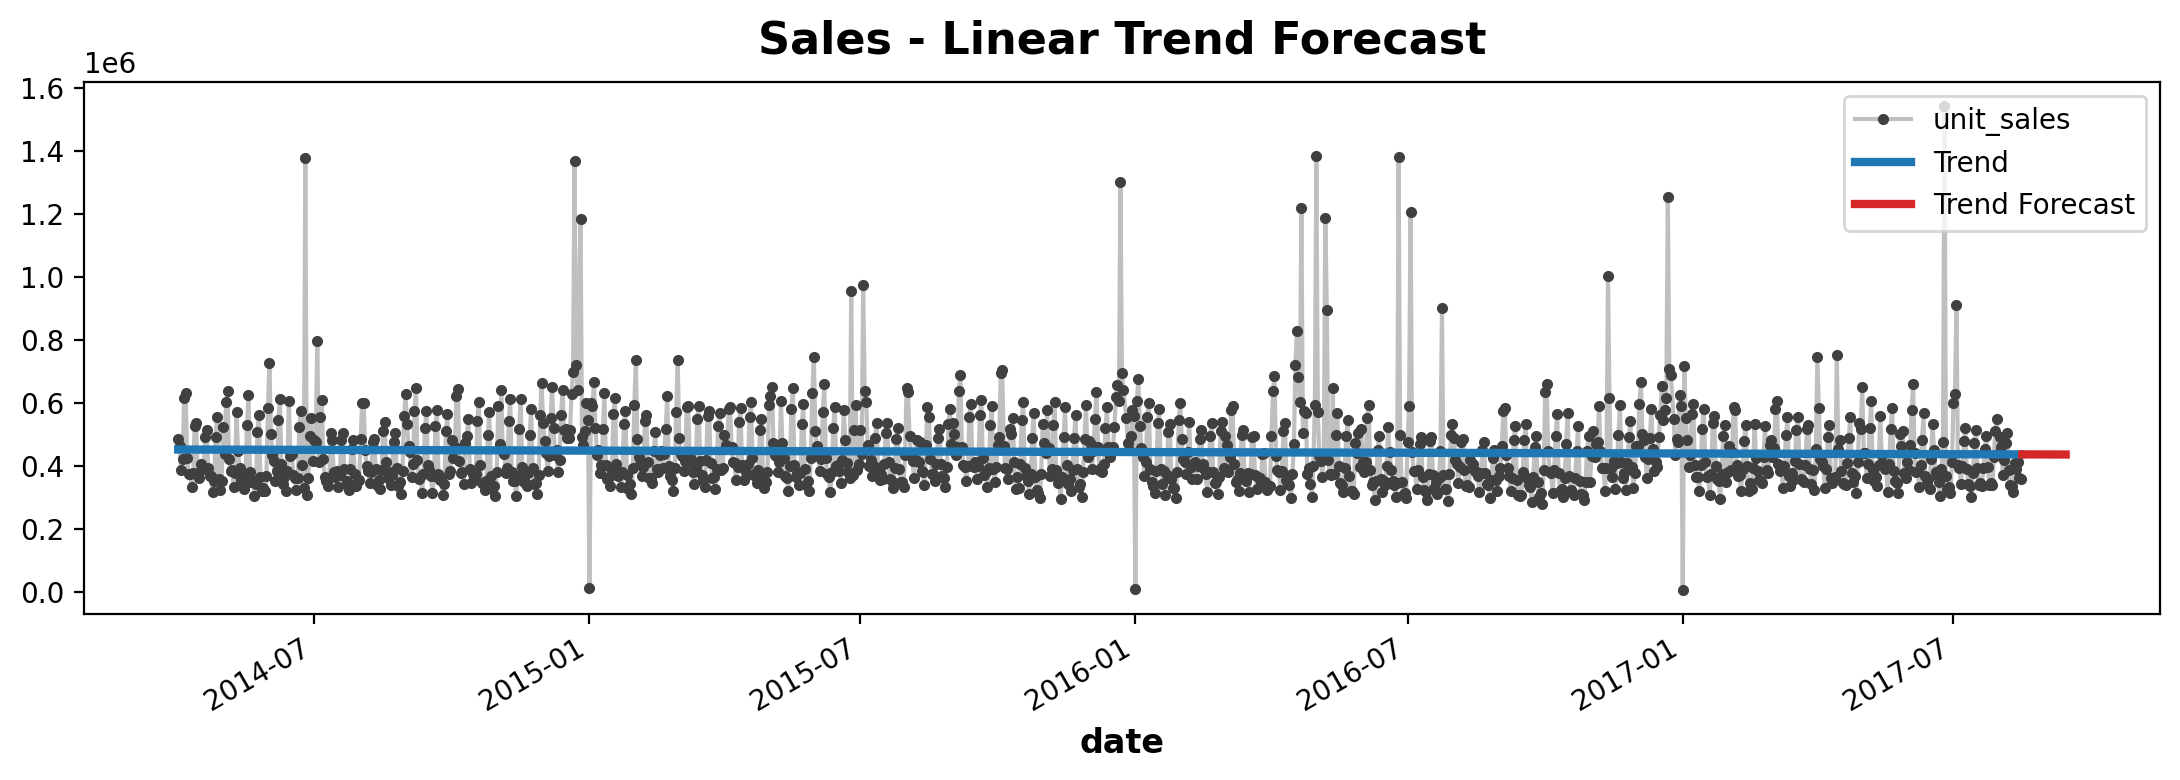

In [51]:
y_forecast = pd.Series(model.predict(out_of_sample_df),
                       index=out_of_sample_df.index)

ax = sales_per_date["unit_sales"].plot(
    title="Sales - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_forecast.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

## Seasonality

In [52]:
sales_per_date = df_train.groupby('date')['unit_sales'].sum().reset_index()
sales_per_date = sales_per_date.set_index('date').to_period('D')

X = sales_per_date.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

X.head()

unit_sales  day  week  dayofyear  year
date                                               
2014-04-01  485078.8870    1    14         91  2014
2014-04-02  463832.9080    2    14         92  2014
2014-04-03  388690.3945    3    14         93  2014
2014-04-04  421434.5332    4    14         94  2014
2014-04-05  617207.2820    5    14         95  2014

/tmp/ipykernel_432125/2914331047.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.


/tmp/ipykernel_432125/2914331047.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.




<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='unit_sales'>

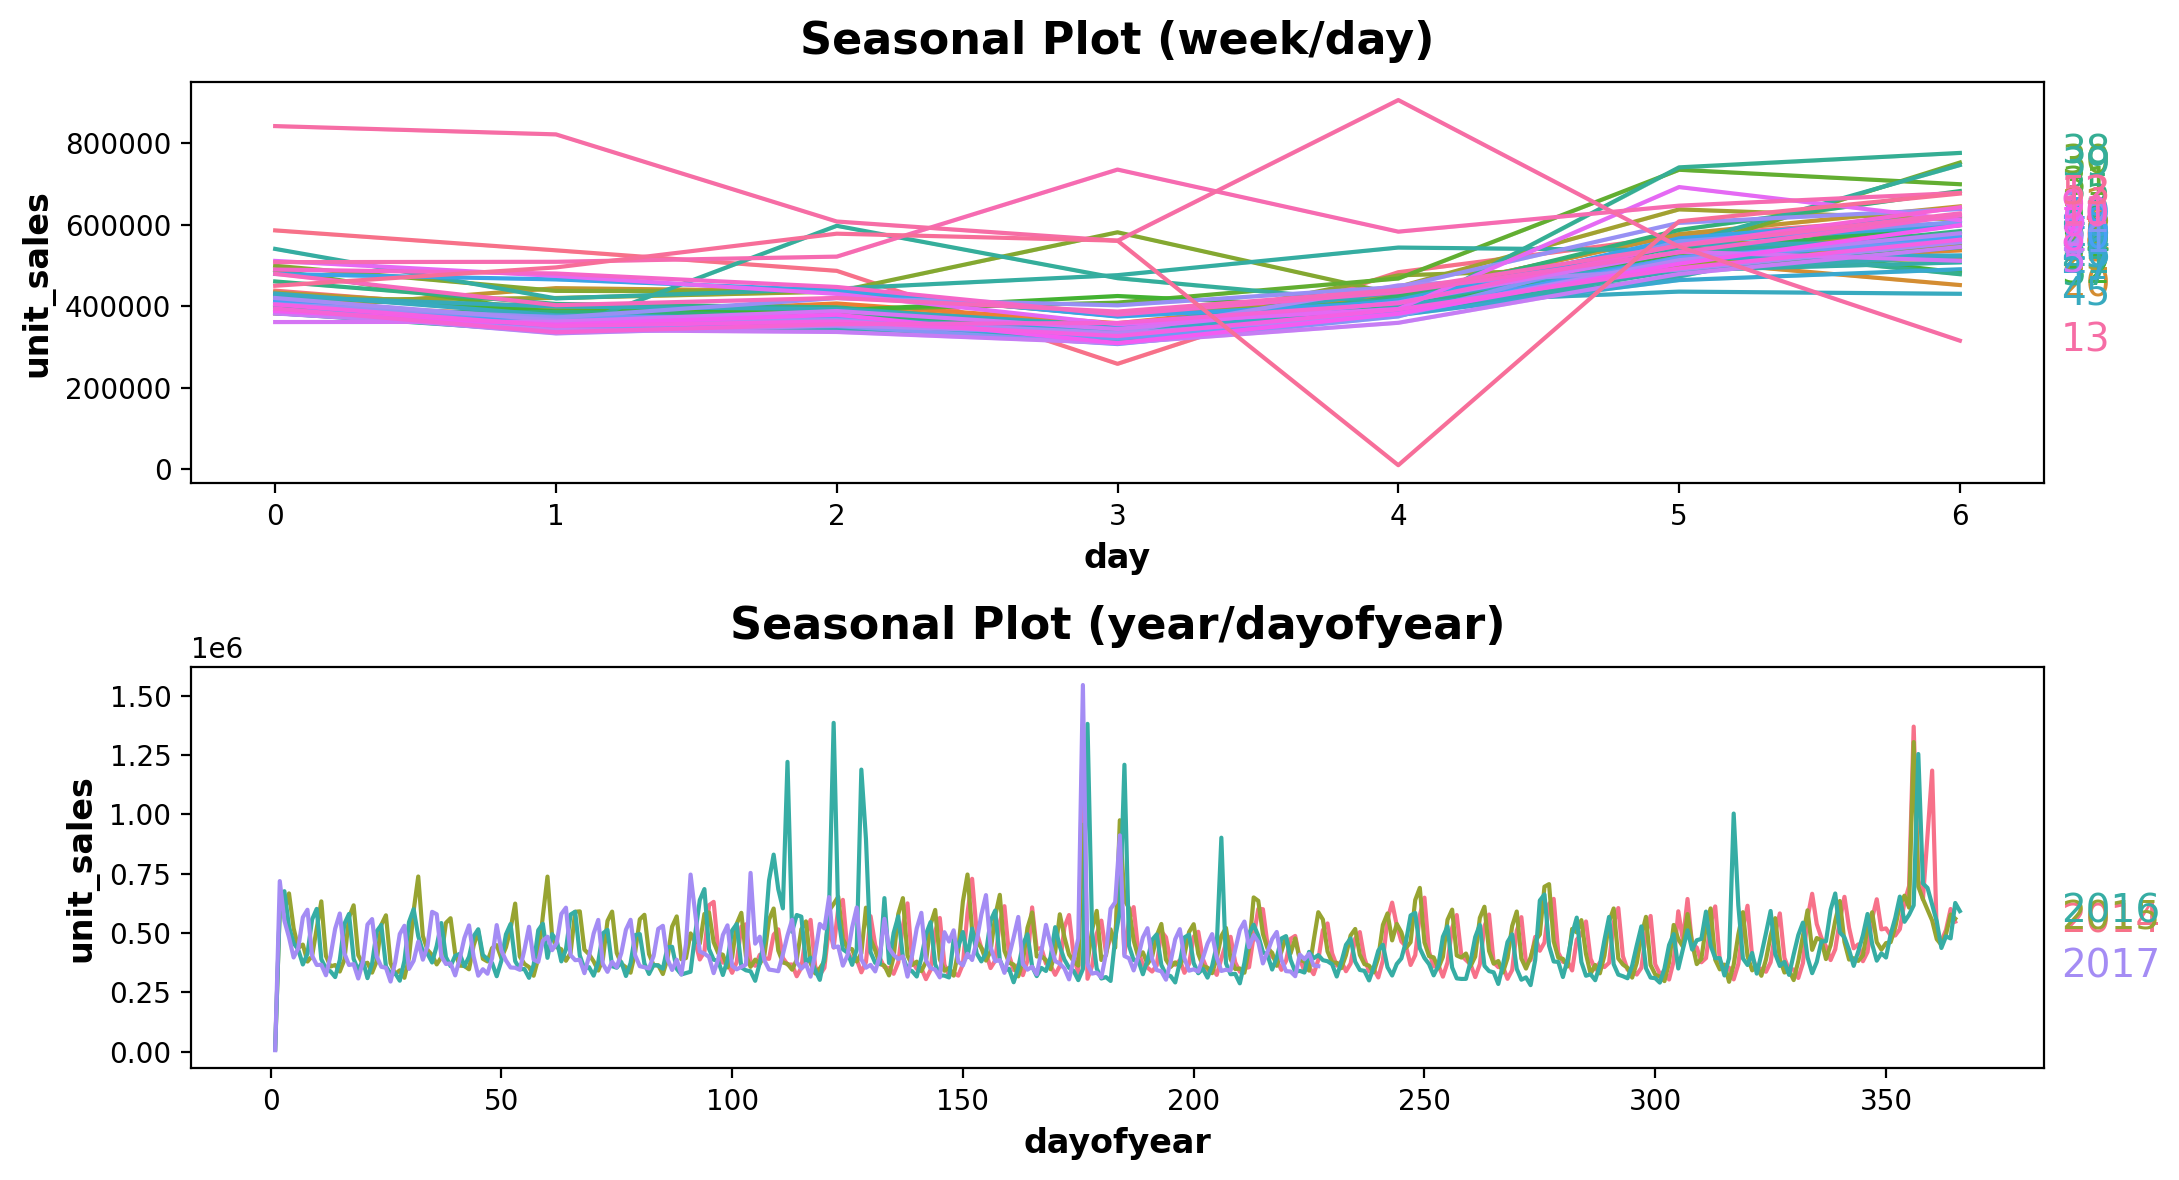

In [53]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="unit_sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="unit_sales", period="year", freq="dayofyear", ax=ax1)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

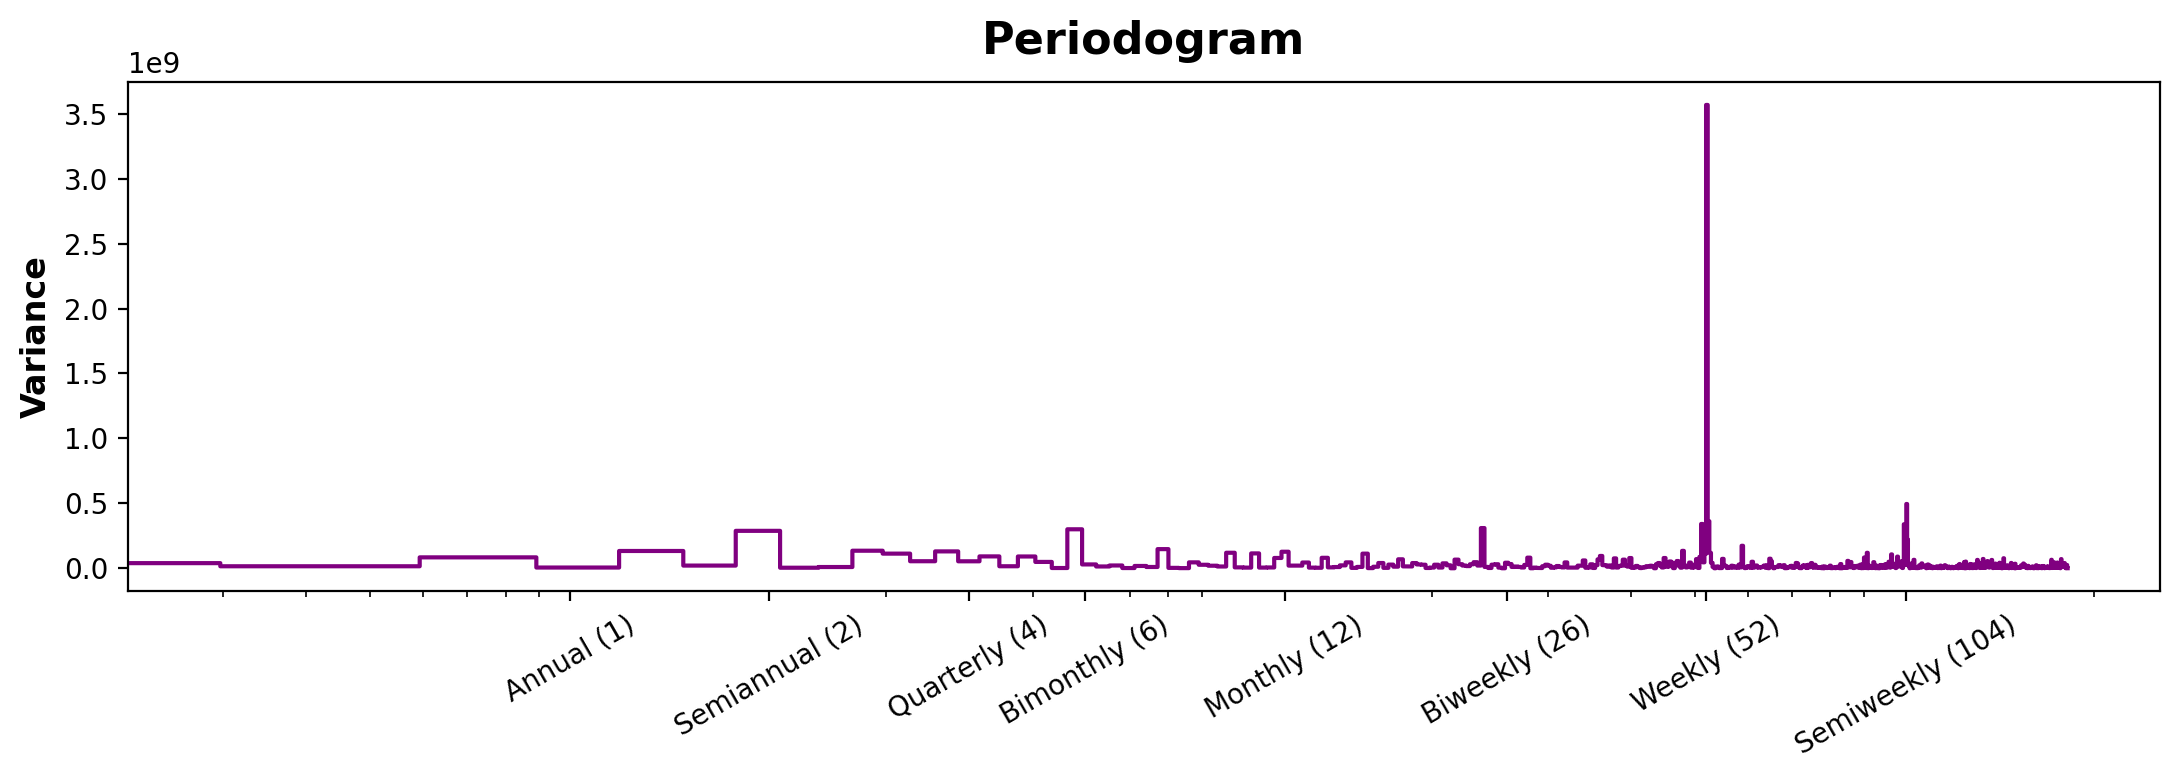

In [54]:
plot_periodogram(sales_per_date.unit_sales)

* Clear Peaks: The periodogram displays clear peaks, notably at the "Weekly (52)" frequency, indicating that there's a significant amount of variance at this frequency. This suggests that the underlying time series data has a strong weekly component.

* Smaller Peaks: There are smaller peaks at "Annual (1)" and "Semiannual (2)" frequencies, indicating some level of seasonal or semi-annual patterns in the data. These peaks may represent yearly or bi-yearly trends or cycles in the data.

* Flat Sections: The sections of the plot between the major peaks are relatively flat, suggesting lower variance and potentially weaker periodic components at those frequencies.

* Weekly Seasonality with Indicators: Since the weekly seasonality is strong, you can model it using indicator (or dummy) variables. These variables would capture the weekly effect by assigning different values for different days of the week (or any other relevant sub-period within the week).
* Annual Seasonality with Fourier Features: Fourier features are used to capture complex seasonal patterns, especially when the seasonality is not as simple as a weekly pattern. Since the annual seasonality is weaker but still present, using Fourier features is a suitable approach. Fourier series can model periodic functions by decomposing them into a sum of sine and cosine functions, which can capture the cyclical nature of the data.
Selecting the Number of Fourier Pairs: The periodogram's variance falls off between "Bimonthly (6)" and "Monthly (12)", suggesting that the complexity of the seasonality decreases as you move from shorter to longer periods. By choosing 10 Fourier pairs, you aim to capture enough of the annual seasonality without overfitting. This means you're using 10 sine and 10 cosine functions to approximate the annual seasonality.

In [55]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# 10 sin/cos pairs for "A"nnual seasonality
fourier = CalendarFourier(freq="A", order=10)

dp = DeterministicProcess(
    index=sales_per_date.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in sales_per_date.index

/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning:

'A' is deprecated and will be removed in a future version, please use 'YE' instead.



In [56]:
y = sales_per_date['unit_sales']  # the target

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_forecast = dp.out_of_sample(steps=90)
y_forecast = pd.Series(model.predict(X_forecast), index=X_forecast.index)

regression_metrics_df(y, y_pred, y, y_pred, 'LinearRegression - seasonality')

Metric  Train Set   Test Set  \
0                        RMSE  120737.59  120737.59   
1                    MAPE (%)      30.60      30.60   
2                    R2 Score       0.18       0.18   
3                         MAE   78065.66   78065.66   
4  Relative Error to Mean (%)      27.10      27.10   

                            Model  
0  LinearRegression - seasonality  
1  LinearRegression - seasonality  
2  LinearRegression - seasonality  
3  LinearRegression - seasonality  
4  LinearRegression - seasonality

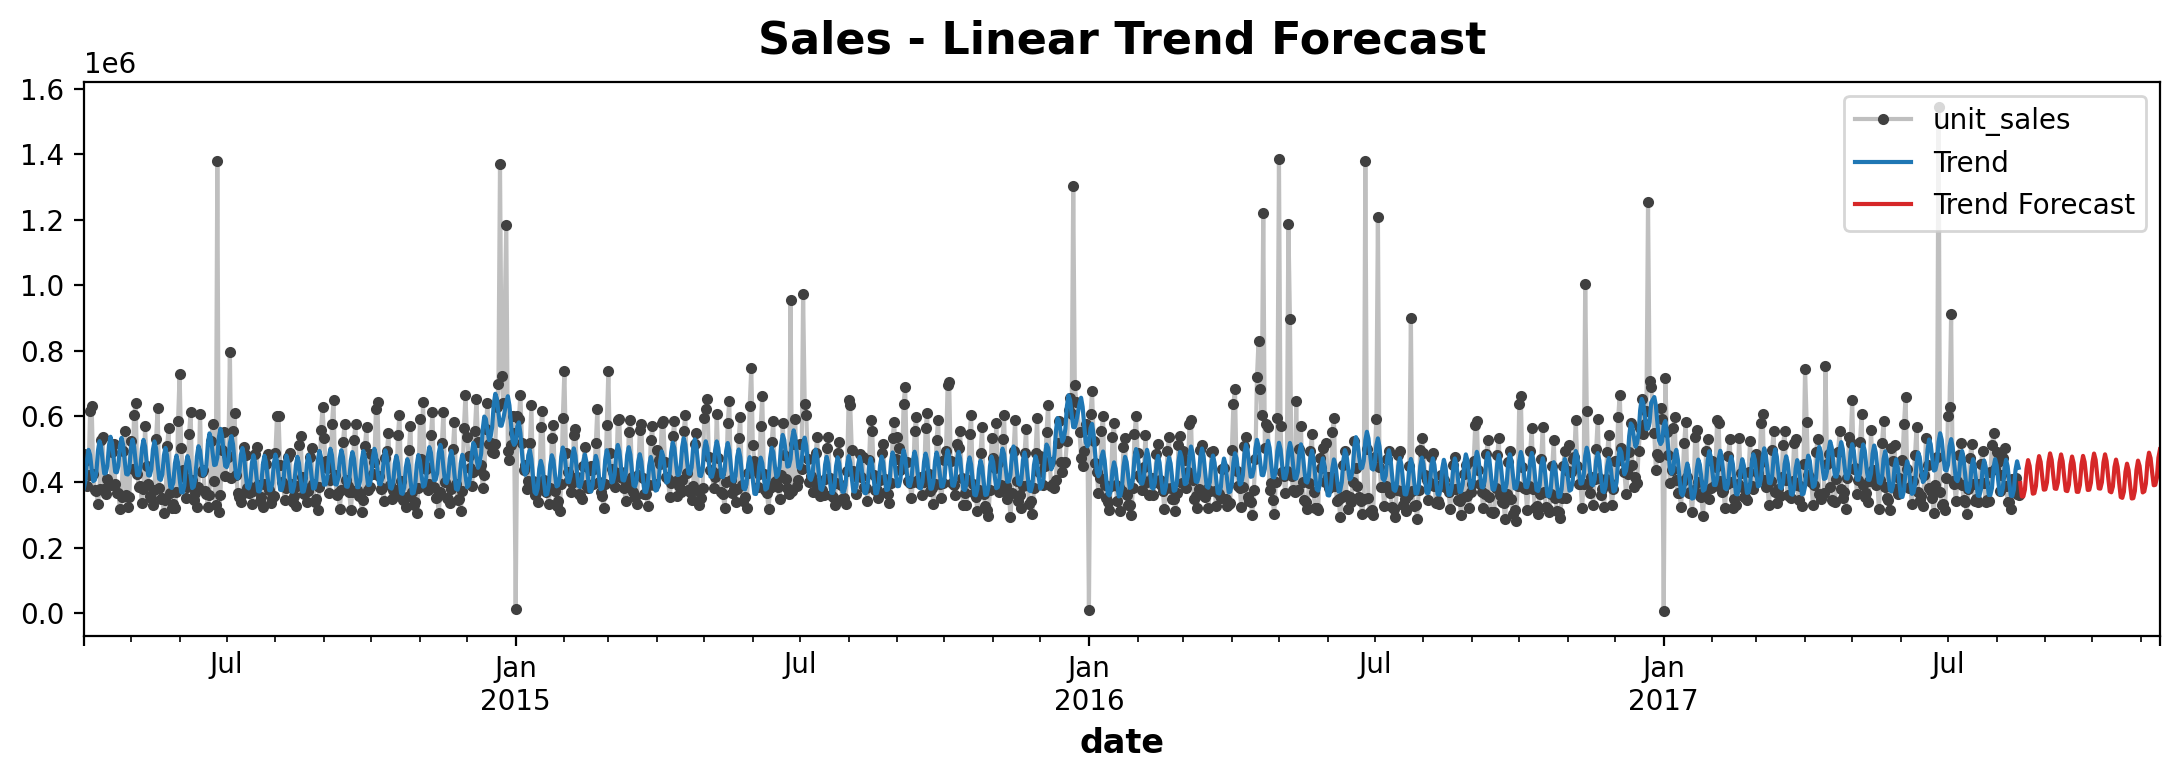

In [57]:
ax = y.plot(title="Sales - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, label="Trend")
ax = y_forecast.plot(ax=ax, label="Trend Forecast", color="C3")
_ = ax.legend()

Time Series as Features - Lags¶
* we saw properties of time series that were most easily modeled as time dependent properties, that is, with features we could derive directly from the time index.
Some time series properties, however, can only be modeled as serially dependent properties, that is, using as features past values of the target series.

* One especially common way for serial dependence to manifest is in cycles. Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself.

* Lagged Series: To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. Lagging a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps.

In [58]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [59]:
sales_per_date = df_train.groupby('date')['unit_sales'].sum().reset_index()
sales_per_date = sales_per_date.set_index('date').to_period('D')
sales_per_date['sales_lag_1'] = sales_per_date['unit_sales'].shift(1)
sales_per_date['sales_lag_2'] = sales_per_date['unit_sales'].shift(2)
sales_per_date.head()

unit_sales  sales_lag_1  sales_lag_2
date                                             
2014-04-01  485078.8870          NaN          NaN
2014-04-02  463832.9080  485078.8870          NaN
2014-04-03  388690.3945  463832.9080  485078.8870
2014-04-04  421434.5332  388690.3945  463832.9080
2014-04-05  617207.2820  421434.5332  388690.3945

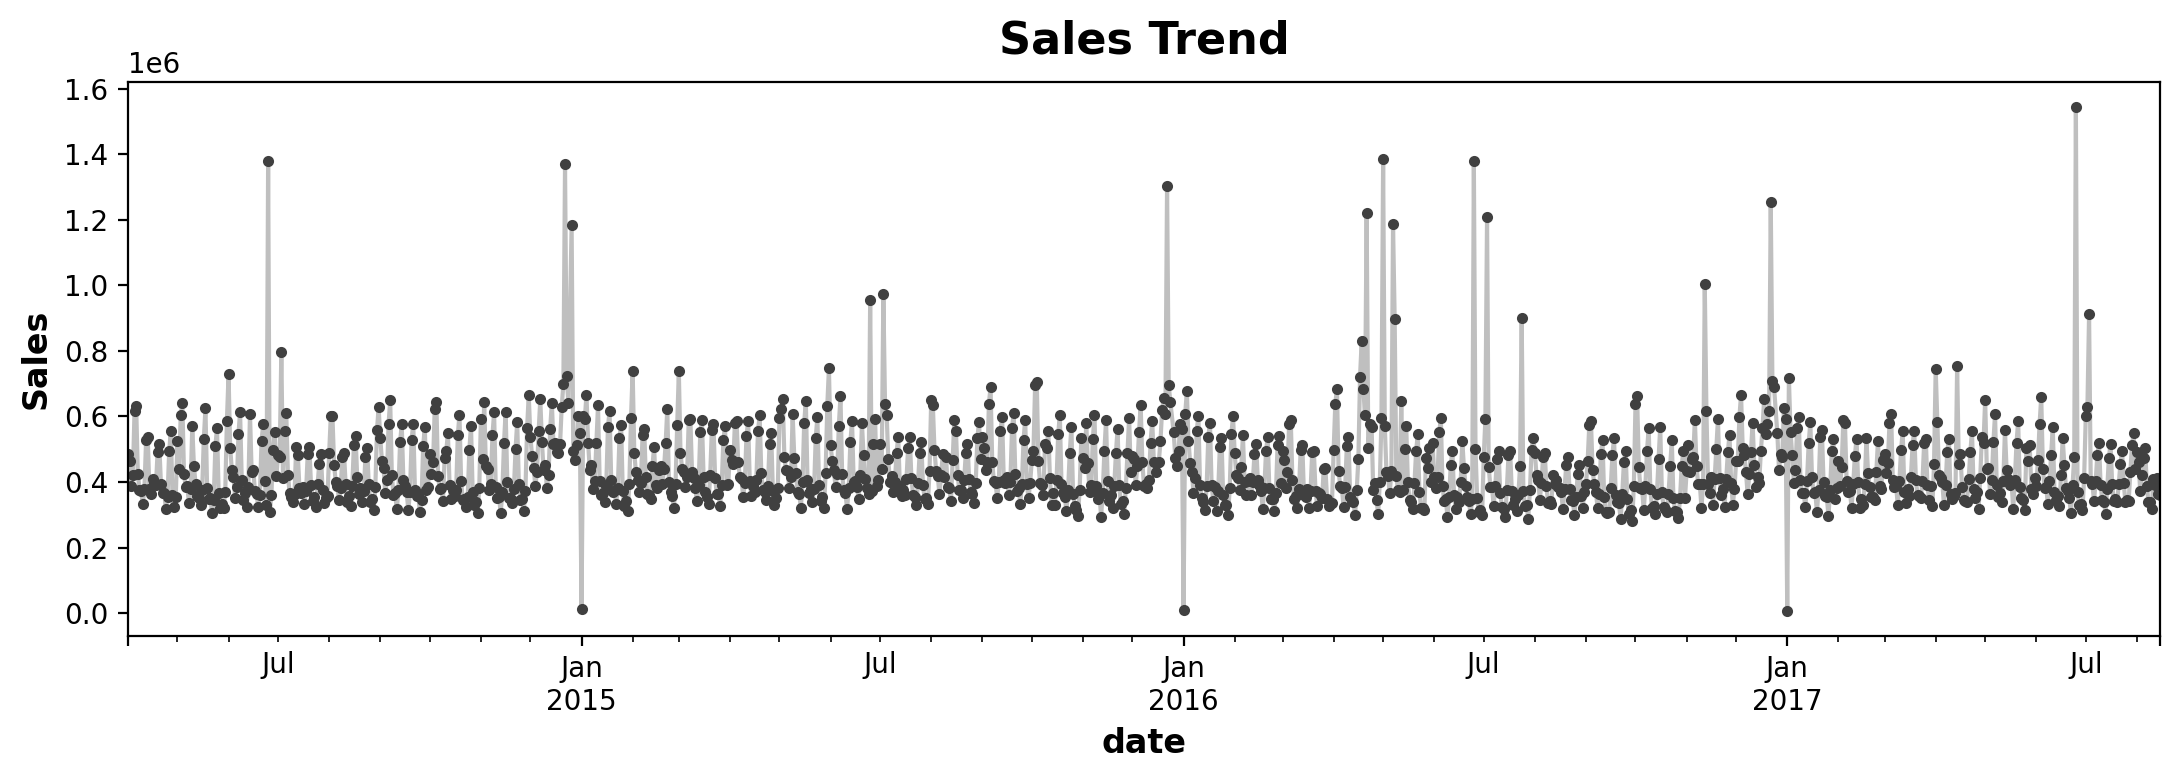

In [60]:
ax = sales_per_date.unit_sales.plot(title='Sales Trend', **plot_params)
_ = ax.set(ylabel="Sales")

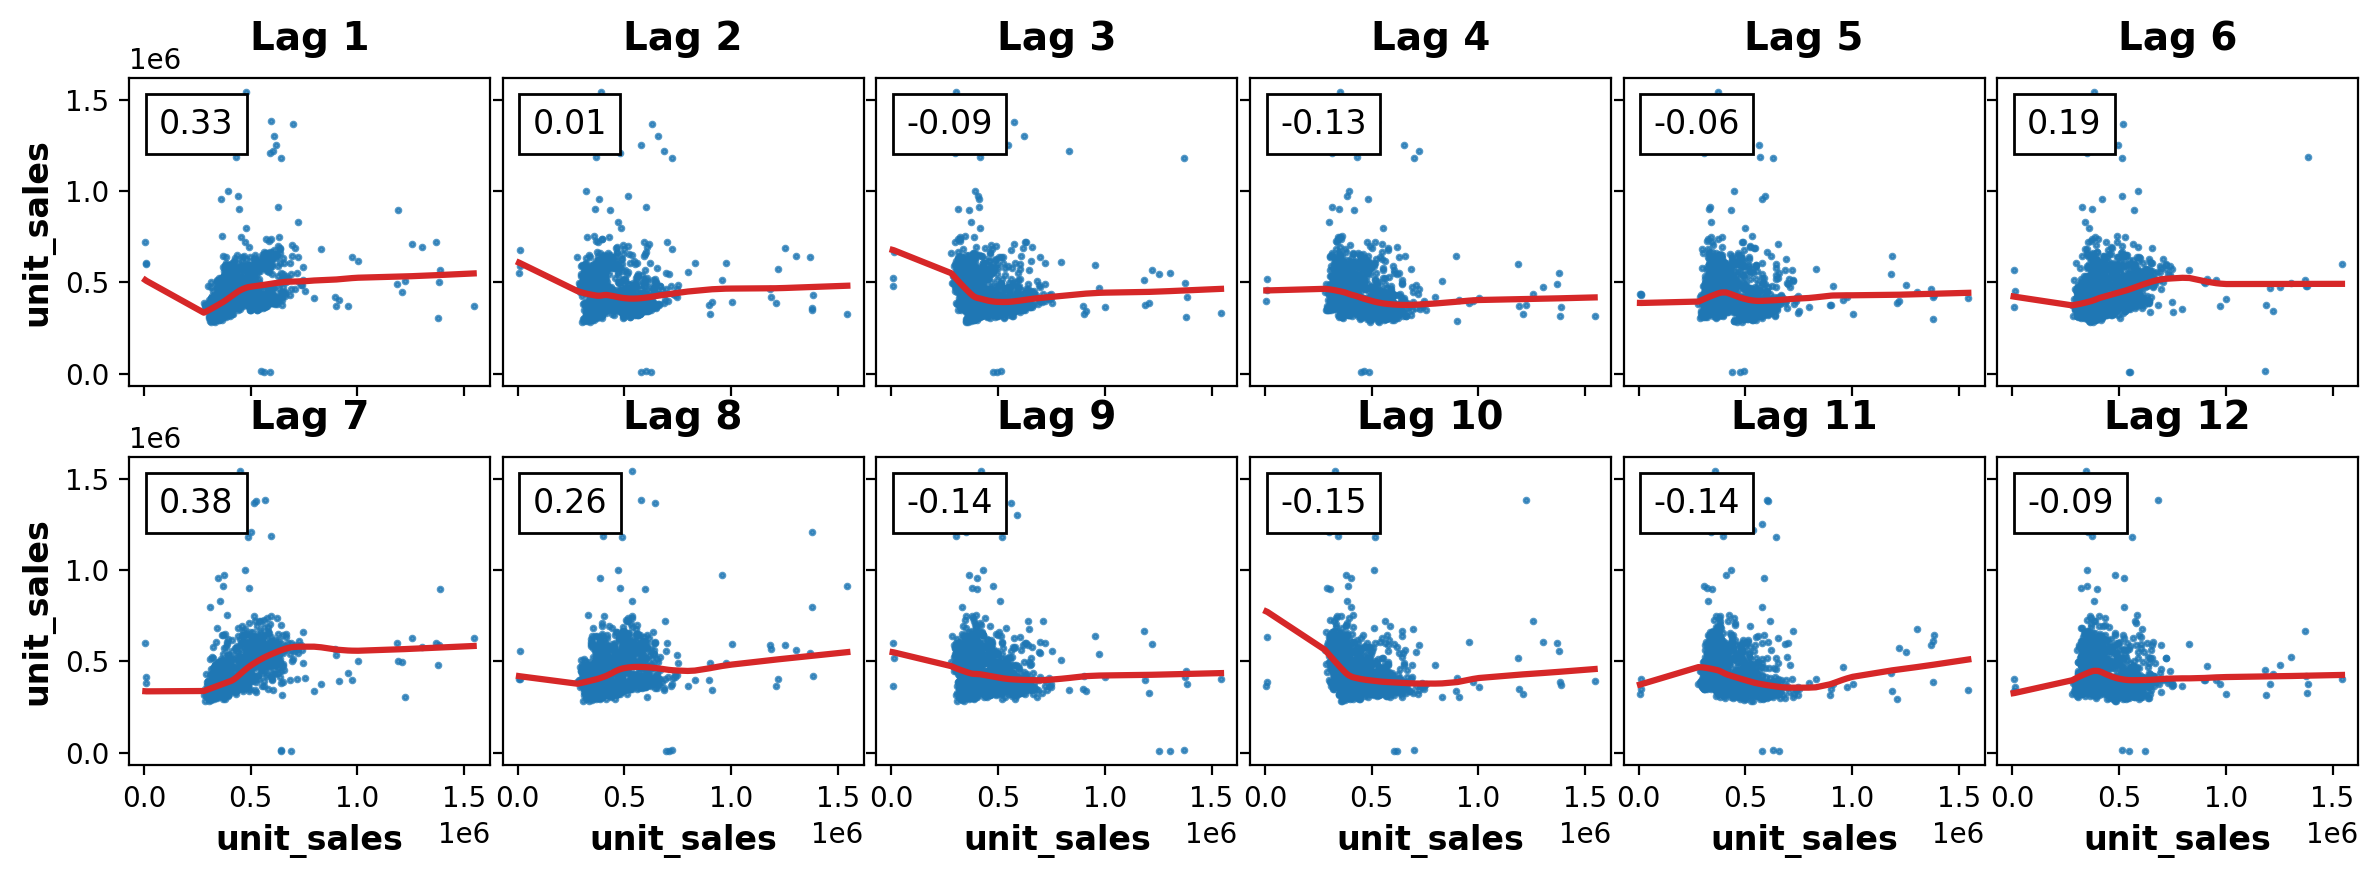

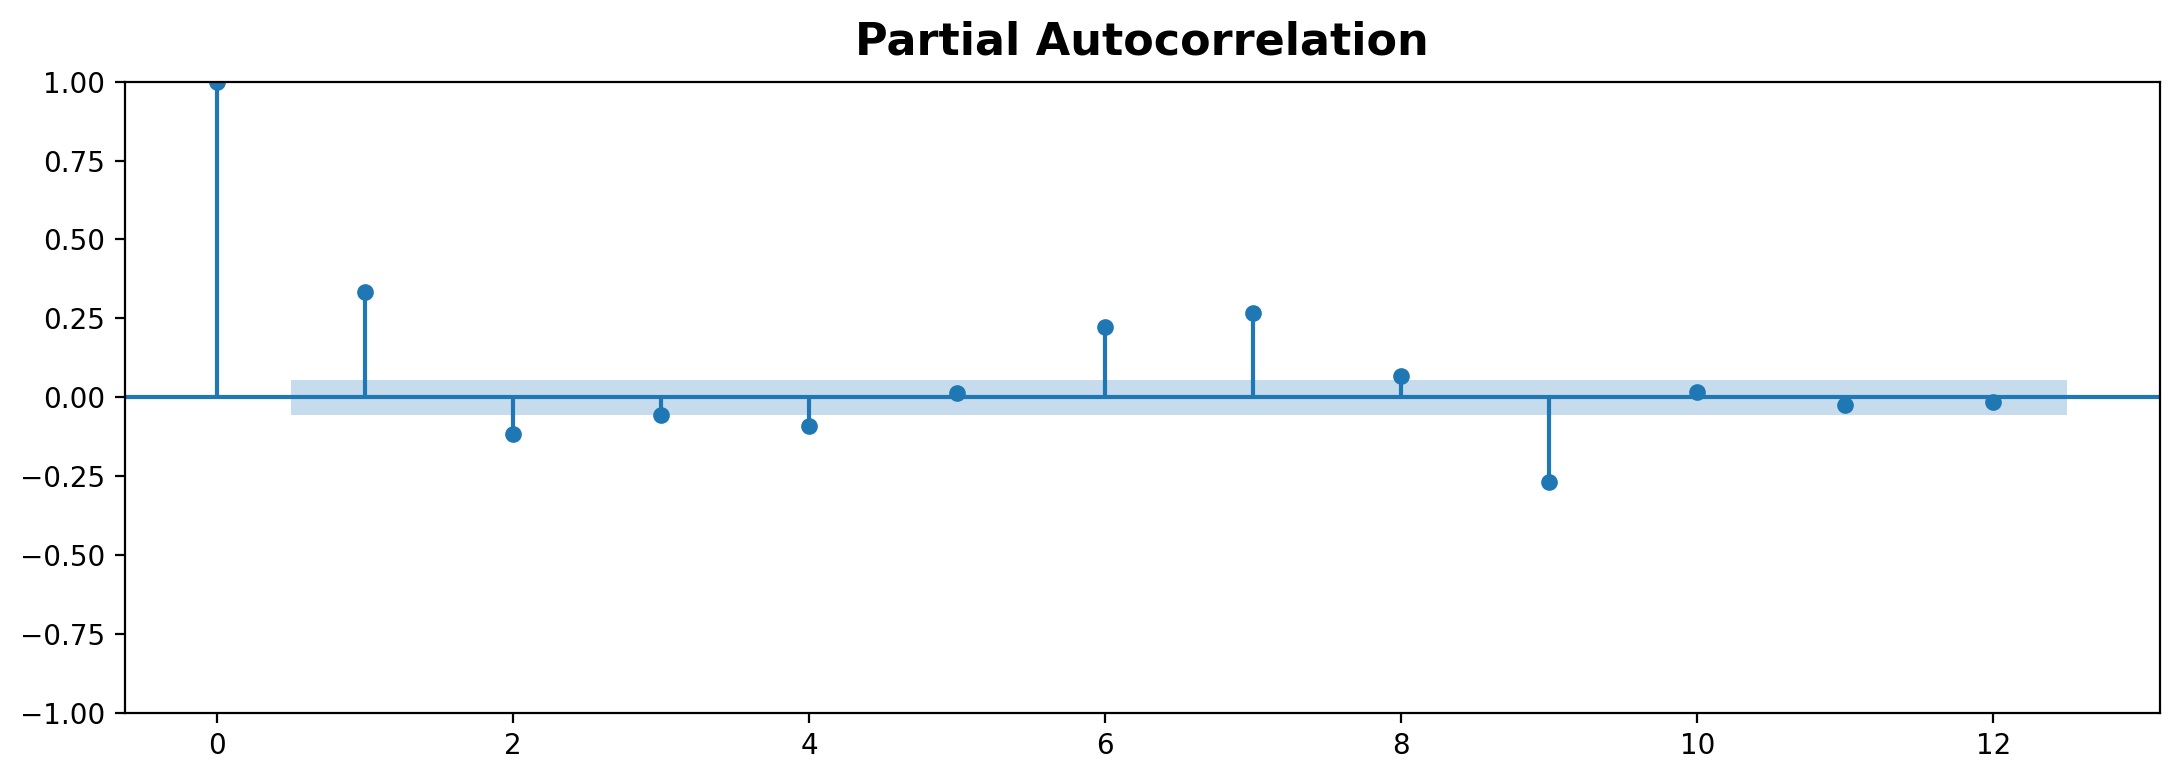

In [61]:
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram

_ = plot_lags(sales_per_date.unit_sales, lags=12, nrows=2)
_ = plot_pacf(sales_per_date.unit_sales, lags=12)

The lag plots indicate that the relationship of sales to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lags 1, 2, 3,.. to 9. We can lag a time series in Pandas with the shift method. For this problem, we'll fill in the missing values the lagging creates with 0.0.

In [62]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [63]:
X = make_lags(sales_per_date.unit_sales, lags=9)
X = X.fillna(0.0)
X.head()

y_lag_1      y_lag_2     y_lag_3     y_lag_4  y_lag_5  \
date                                                                    
2014-04-01       0.0000       0.0000       0.000       0.000      0.0   
2014-04-02  485078.8870       0.0000       0.000       0.000      0.0   
2014-04-03  463832.9080  485078.8870       0.000       0.000      0.0   
2014-04-04  388690.3945  463832.9080  485078.887       0.000      0.0   
2014-04-05  421434.5332  388690.3945  463832.908  485078.887      0.0   

            y_lag_6  y_lag_7  y_lag_8  y_lag_9  
date                                            
2014-04-01      0.0      0.0      0.0      0.0  
2014-04-02      0.0      0.0      0.0      0.0  
2014-04-03      0.0      0.0      0.0      0.0  
2014-04-04      0.0      0.0      0.0      0.0  
2014-04-05      0.0      0.0      0.0      0.0

In [64]:
# Create target series and data splits
y = sales_per_date.unit_sales.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=60, shuffle=False)

# Fit and predict
# `fit_intercept=True` since we didn't use DeterministicProcess
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

In [65]:
regression_metrics_df(y_train, y_pred, y_test, y_fore,
                      'LinearRegression - lags')

Metric  Train Set   Test Set                    Model
0                        RMSE  109468.83  164024.87  LinearRegression - lags
1                    MAPE (%)      22.80      15.60  LinearRegression - lags
2                    R2 Score       0.30       0.11  LinearRegression - lags
3                         MAE   63023.09   76463.14  LinearRegression - lags
4  Relative Error to Mean (%)      24.60      37.60  LinearRegression - lags

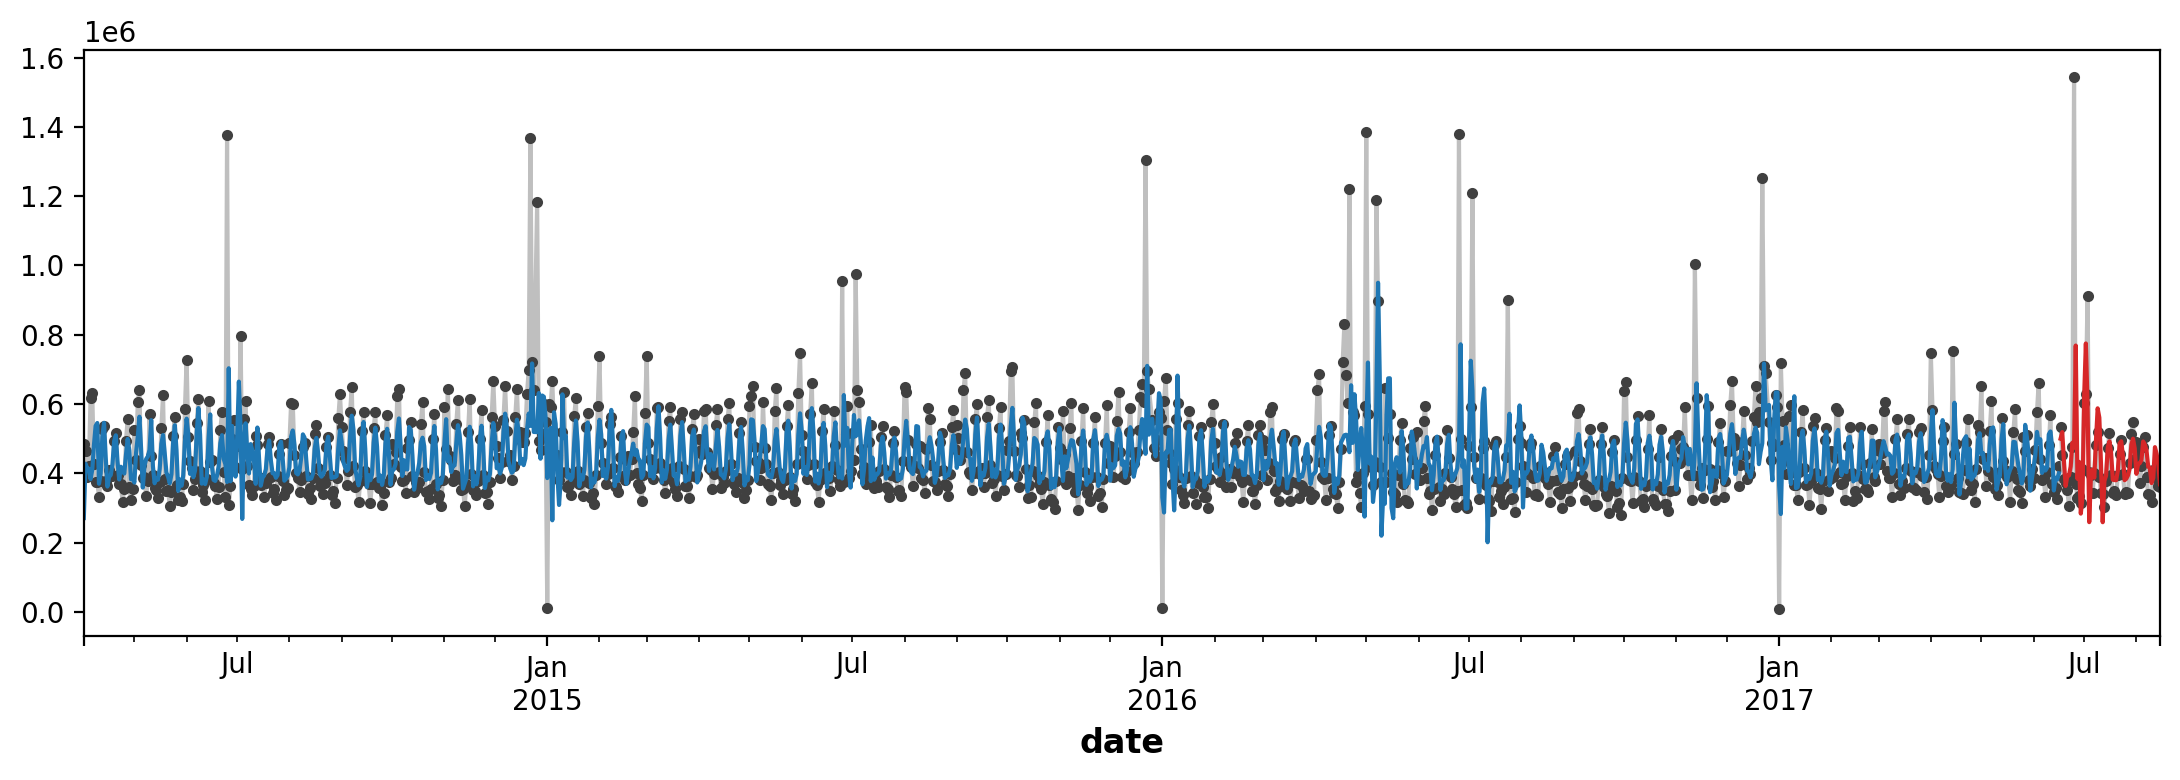

In [66]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

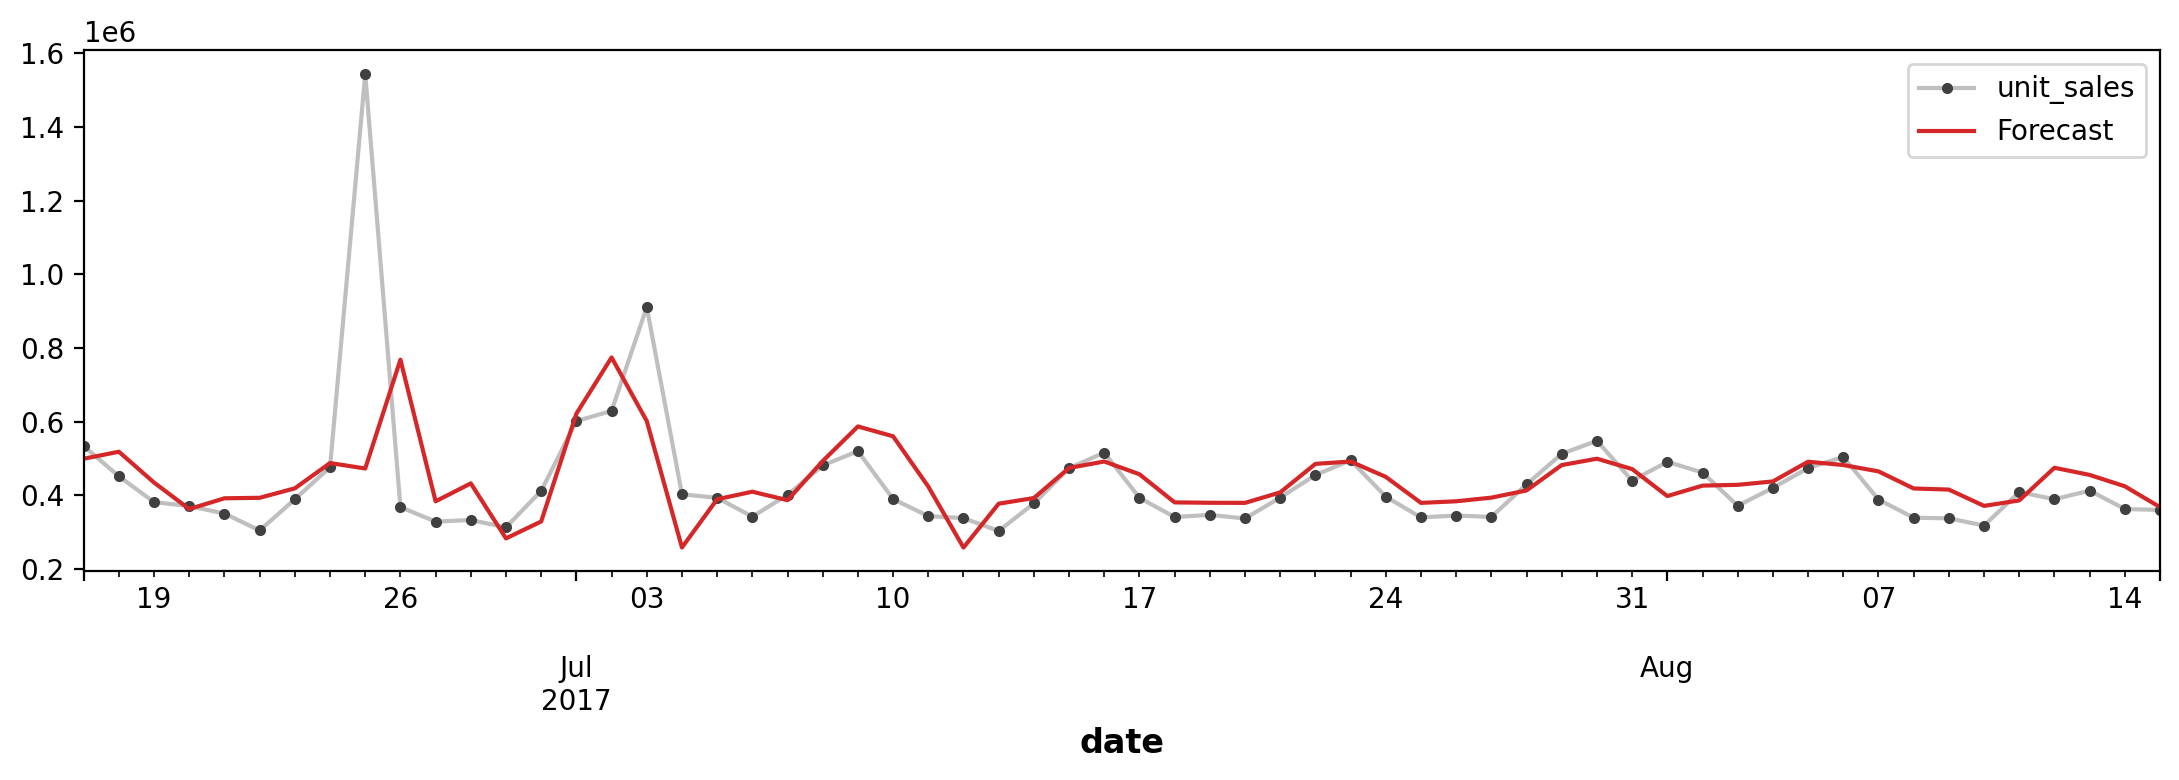

In [67]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3', label='Forecast')
_ = ax.legend()

# XGBoost Model

In [7]:
df_train.columns

Index(['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion', 'family',
       'perishable', 'type_store', 'cluster', 'type_holiday', 'transferred'],
      dtype='object')

In [6]:
df_train = df_train.drop(columns=['item_nbr','type_store', 'transferred'])

In [7]:
# Add custom features for train data
def add_custom_features(df):
    # Ensure 'date' column is datetime type
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df['date'].dt.weekday
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['eomd'] = df['date'].apply(
        lambda x: calendar.monthrange(x.year, x.month)[1])
    df['payday'] = ((df['day'] == 15) | (df['day'] == df['eomd'])).astype(int)
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    df.drop(['eomd'], axis=1, inplace=True)  # Drop unnecessary columns
    return df


# Apply custom features to both train and test data
train_data = add_custom_features(df_train)

In [8]:
def add_lag_features(df, lags):
    for lag in lags:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])[
            'unit_sales'].transform(lambda x: x.shift(lag))
    return df

In [9]:
def add_random_noise(df):
    return np.random.normal(scale=2.0, size=(len(df),))

In [10]:
def add_rolling_mean_features(df, windows):
    for window in windows:
        df[f'sales_roll_mean_{window}'] = df.groupby(['store_nbr', 'family'])['unit_sales'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()) + add_random_noise(df)
    return df

In [11]:
def add_ewm_features(df, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            df[f'sales_ewm_alpha_{str(alpha).replace(".", "")}_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['unit_sales'].transform(
                lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return df

In [12]:
# Specify the lags, rolling windows, and EWM parameters
lags = [7, 30]
windows = [7, 30]
ewm_alphas = [0.95, 0.9, 0.8]
ewm_lags = [7, 30]

# Apply lag features
data = add_lag_features(train_data, lags)

# Apply rolling mean features
data = add_rolling_mean_features(data, windows)

# Apply EWM features
data = add_ewm_features(data, ewm_alphas, ewm_lags)

In [13]:
data.fillna(0, inplace=True)

In [14]:
# Split back into train and test data
train_data = data[data['date'] <= '2017-08-15'].copy()
test_data = data[data['date'] > '2017-08-15'].copy()

In [15]:
# List of categorical features to encode
cat_features = ['family', 'onpromotion', 'store_nbr', 'perishable', 'cluster', 'type_holiday', 'is_weekend']

train_data_encoded = train_data
test_data_encoded = test_data

# Ensure all values in categorical columns are of string type
train_data_encoded[cat_features] = train_data_encoded[cat_features].astype(str)
test_data_encoded[cat_features] = test_data_encoded[cat_features].astype(str)

# Apply Label Encoding
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    train_data_encoded[col] = le.fit_transform(train_data[col])
    test_data_encoded[col] = le.transform(test_data[col])
    label_encoders[col] = le

In [16]:
del train_data
del data

In [17]:
train_data_encoded.head()

date  store_nbr  unit_sales  onpromotion  family  perishable  cluster  \
0 2014-04-01          0         1.0            0       9           0        4   
1 2014-04-01          0         3.0            0       3           1        4   
2 2014-04-01          0         1.0            0       9           0        4   
3 2014-04-01          0        11.0            0       9           0        4   
4 2014-04-01          0         4.0            0       9           0        4   

   type_holiday  weekday  year  ...  sales_lag_7  sales_lag_30  \
0             4        1  2014  ...          0.0           0.0   
1             4        1  2014  ...          0.0           0.0   
2             4        1  2014  ...          0.0           0.0   
3             4        1  2014  ...          0.0           0.0   
4             4        1  2014  ...          0.0           0.0   

   sales_roll_mean_7  sales_roll_mean_30  sales_ewm_alpha_095_lag_7  \
0           0.000000            0.000000                        0.0   
1           0.000000            0.000000                        0.0   
2           1.172208           -0.612083                        0.0   
3           2.312253            3.649751                        0.0   
4           3.399322            5.535918                        0.0   

   sales_ewm_alpha_095_lag_30  sales_ewm_alpha_09_lag_7  \
0                         0.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                       0.0   

   sales_ewm_alpha_09_lag_30  sales_ewm_alpha_08_lag_7  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0                       0.0   

   sales_ewm_alpha_08_lag_30  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  

[5 rows x 24 columns]

In [18]:
test_data_encoded.nunique()

date                          0
store_nbr                     0
unit_sales                    0
onpromotion                   0
family                        0
perishable                    0
cluster                       0
type_holiday                  0
weekday                       0
year                          0
month                         0
day                           0
payday                        0
is_weekend                    0
sales_lag_7                   0
sales_lag_30                  0
sales_roll_mean_7             0
sales_roll_mean_30            0
sales_ewm_alpha_095_lag_7     0
sales_ewm_alpha_095_lag_30    0
sales_ewm_alpha_09_lag_7      0
sales_ewm_alpha_09_lag_30     0
sales_ewm_alpha_08_lag_7      0
sales_ewm_alpha_08_lag_30     0
dtype: int64

In [19]:
train_data_encoded.to_csv("data/train_data_encoded.csv", index=False)
test_data_encoded.to_csv("data/test_data_encoded.csv", index=False)

In [21]:
# Drop the original categorical columns since they are now encoded
train_data_encoded.drop(['date'], axis=1, inplace=True)
test_data_encoded.drop(['date'], axis=1, inplace=True)

In [22]:
corr_matrix = train_data_encoded.corr()

In [23]:
correlation_with_sales = corr_matrix['unit_sales']

In [24]:
# Use the absolute values of the correlations
abs_correlation_with_sales = correlation_with_sales.abs()

# Get summary statistics for the absolute correlation with 'sales'
correlation_summary = abs_correlation_with_sales.describe()

# Print the summary statistics
print(correlation_summary)

count    23.000000
mean      0.091519
std       0.203173
min       0.000055
25%       0.018284
50%       0.051359
75%       0.061137
max       1.000000
Name: unit_sales, dtype: float64


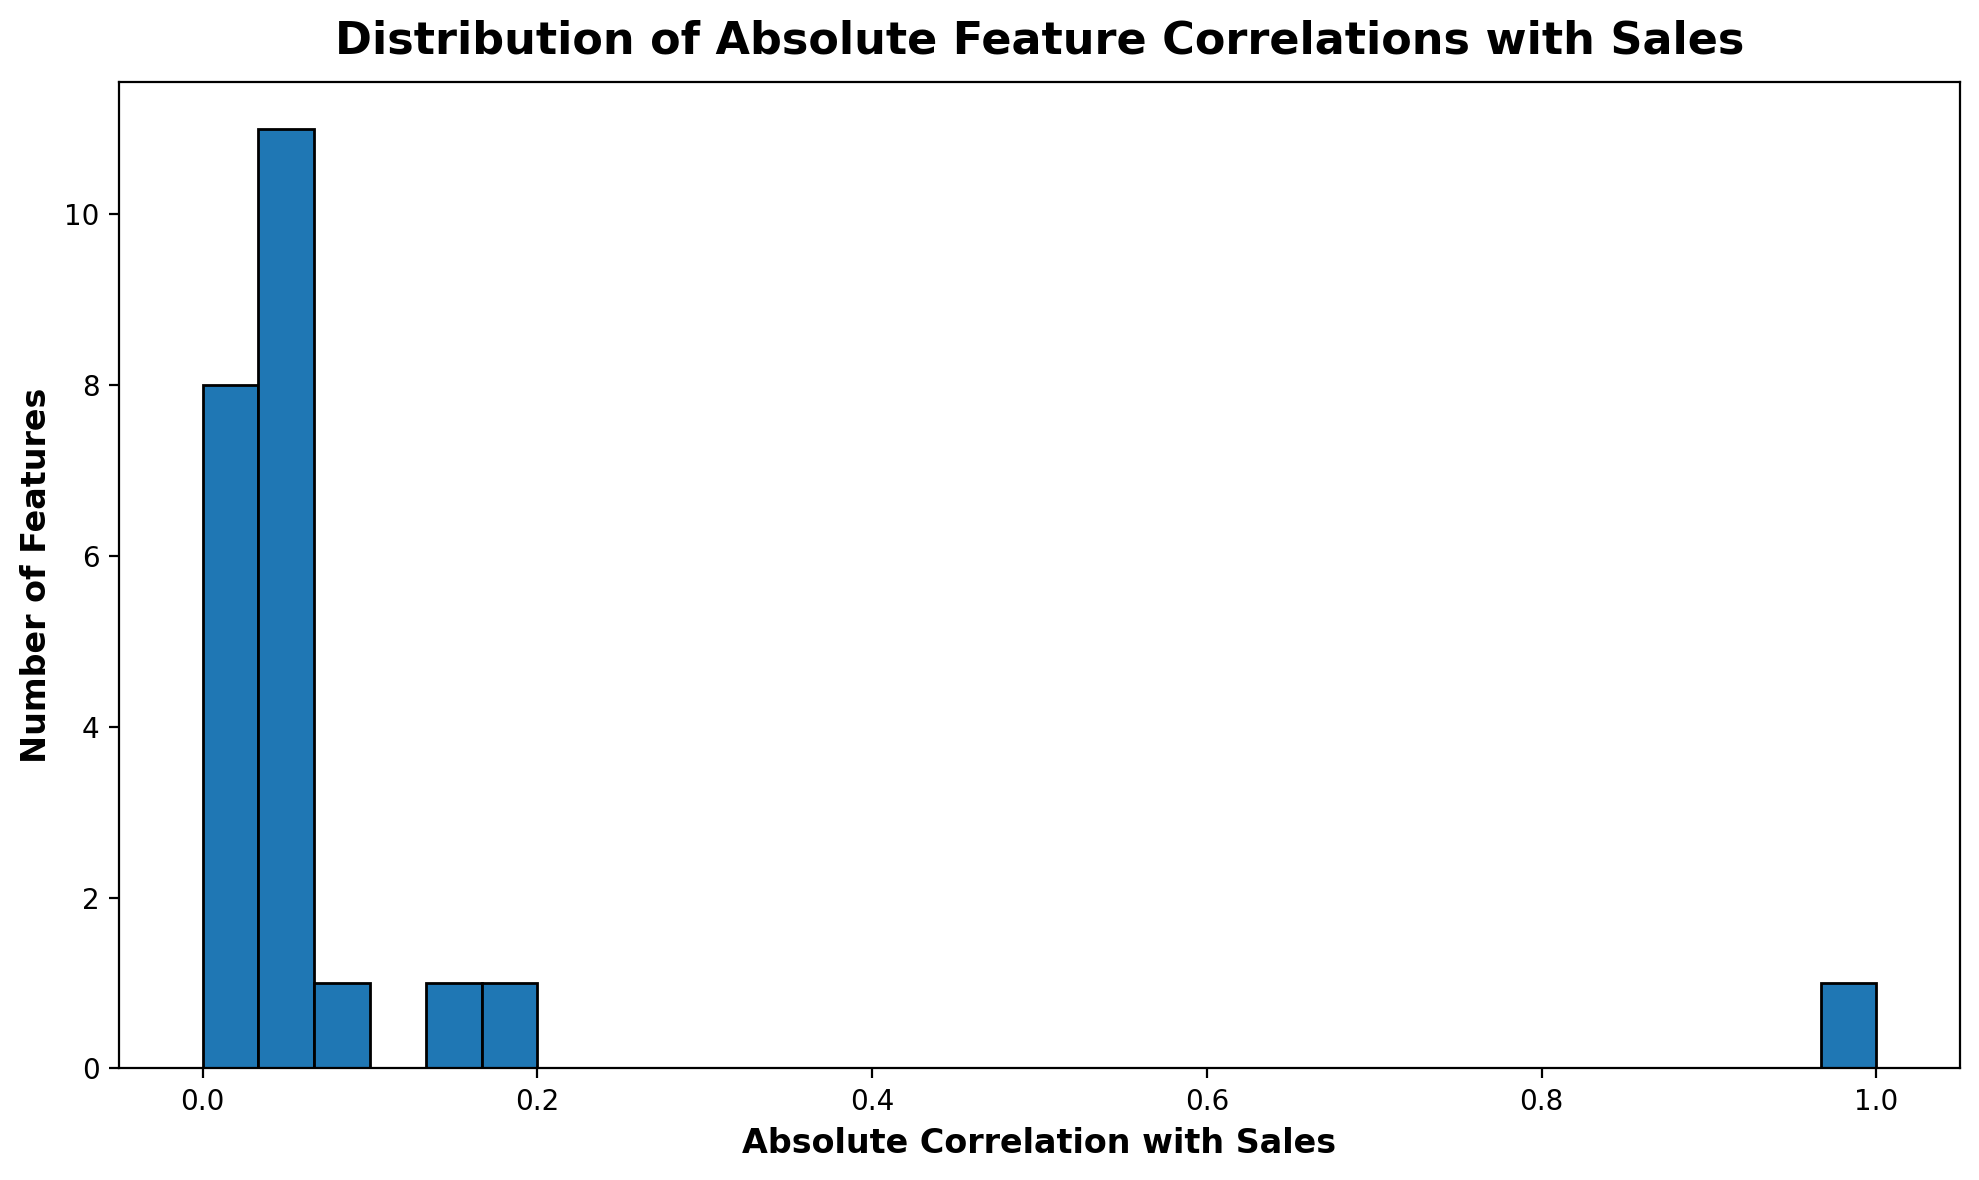

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(abs_correlation_with_sales, bins=30, edgecolor='black')
plt.title('Distribution of Absolute Feature Correlations with Sales')
plt.xlabel('Absolute Correlation with Sales')
plt.ylabel('Number of Features')
plt.show()

In [26]:
low_correlation_threshold = 0.01

# Identify features with correlation below
low_correlation_features = abs_correlation_with_sales[abs_correlation_with_sales <= low_correlation_threshold]

# Print the features with the low correlation
print("Features with low correlation to 'sales':")
print(low_correlation_features)

Features with low correlation to 'sales':
cluster         0.002603
type_holiday    0.007006
month           0.008667
payday          0.000055
Name: unit_sales, dtype: float64


In [27]:
# Drop low-correlation features from the dataset
train_data_encoded = train_data_encoded.drop(columns=low_correlation_features.index)

In [28]:
# Drop only the features that exist in the test dataset
common_features = low_correlation_features.index.intersection(test_data_encoded.columns)
test_data_encoded = test_data_encoded.drop(columns=common_features)

In [48]:
train_data_encoded.to_csv("data/train_data_encoded.csv", index=False)
test_data_encoded.to_csv("data/test_data_encoded.csv", index=False)

In [29]:
# Define the target and features
X = train_data_encoded.drop(columns=['unit_sales'])
y = train_data_encoded['unit_sales']

In [30]:
import xgboost
trial = 50
params = {
        # 'tree_method': 'gpu_hist',  
        'tree_method': 'hist',  
        'n_jobs': -1,  
        'objective': 'reg:squarederror',
        'n_estimators': 100,
        'verbosity': 2,
        'learning_rate': 0.01,
        'max_depth': 14,
        'subsample': 1.0,
        'colsample_bytree': 0.3,
        'min_child_weight': 10,
        'reg_lambda': 0.01,
        'colsample_bynode': 0.6
    }

model = xgboost.XGBRegressor(**params)

In [31]:
# Assuming train_data_encoded is your preprocessed DataFrame sorted by time
subset_frac = 0.20
subset_size = int(len(train_data_encoded) * subset_frac)
subsample_train_data = train_data_encoded.iloc[-subset_size:]

In [32]:
# Split features and target
X_subsample = subsample_train_data.drop(columns=["unit_sales"])
y_subsample = subsample_train_data["unit_sales"]

In [33]:
# Time-based train-validation split within the subset
split_index = int(0.8 * len(X_subsample))
X_sub_train, X_sub_val = X_subsample.iloc[:
                                          split_index], X_subsample.iloc[split_index:]
y_sub_train, y_sub_val = y_subsample.iloc[:
                                          split_index], y_subsample.iloc[split_index:]

In [34]:
model.fit(X_subsample, y_subsample, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.6, colsample_bytree=0.3,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [35]:
test_data_encoded = test_data_encoded[X.columns]

In [36]:
test_data_encoded.columns

Index(['store_nbr', 'onpromotion', 'family', 'perishable', 'weekday', 'year',
       'day', 'is_weekend', 'sales_lag_7', 'sales_lag_30', 'sales_roll_mean_7',
       'sales_roll_mean_30', 'sales_ewm_alpha_095_lag_7',
       'sales_ewm_alpha_095_lag_30', 'sales_ewm_alpha_09_lag_7',
       'sales_ewm_alpha_09_lag_30', 'sales_ewm_alpha_08_lag_7',
       'sales_ewm_alpha_08_lag_30'],
      dtype='object')

In [37]:
# Predict on the test data
y_pred = pd.Series(model.predict(X), index=train_data_encoded.index)
y_fore = pd.Series(model.predict(test_data_encoded), index=test_data_encoded.index)

/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/raziel/Documents/Kiosko/Challenge-Data-Scientist/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


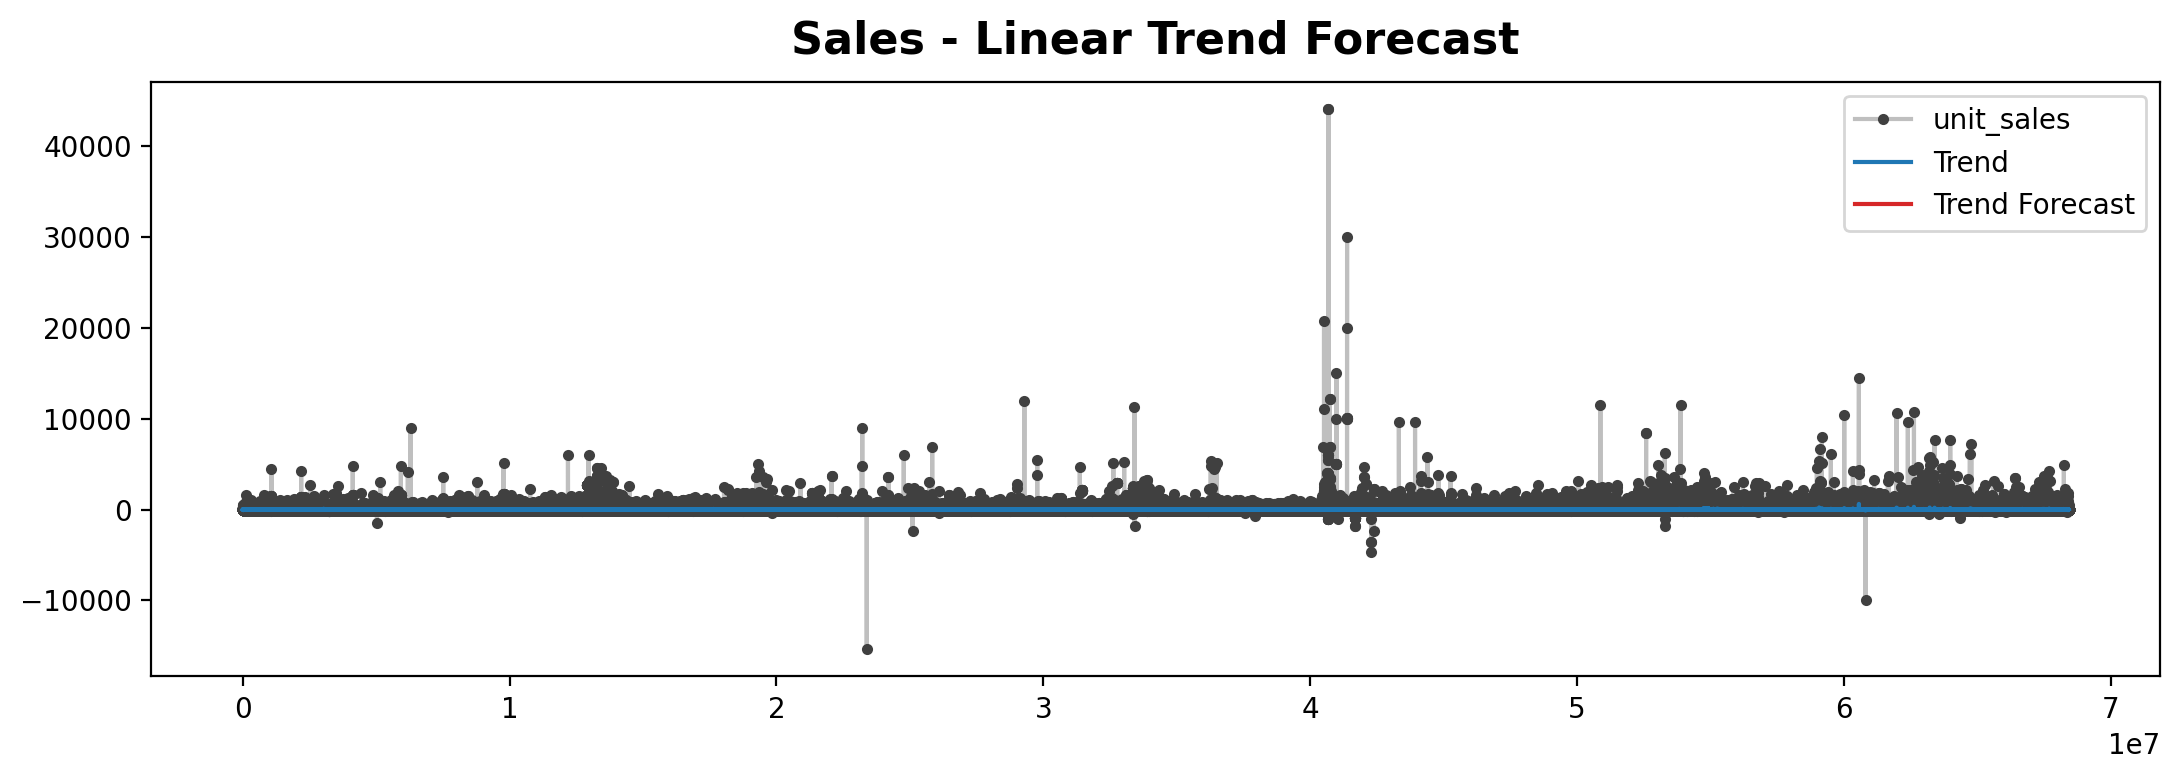

In [38]:
ax = y.plot(title="Sales - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, label="Trend")
ax = y_fore.plot(ax=ax, label="Trend Forecast", color="C3")
_ = ax.legend()

In [45]:
X

store_nbr  onpromotion  family  perishable  weekday  year  day  \
0                 0            0       9           0        1  2014    1   
1                 0            0       3           1        1  2014    1   
2                 0            0       9           0        1  2014    1   
3                 0            0       9           0        1  2014    1   
4                 0            0       9           0        1  2014    1   
...             ...          ...     ...         ...      ...   ...  ...   
68422549         49            1       9           0        1  2017   15   
68422550         49            0       9           0        1  2017   15   
68422551         49            0      17           0        1  2017   15   
68422552         49            0      17           0        1  2017   15   
68422553         49            0       2           0        1  2017   15   

          is_weekend  sales_lag_7  sales_lag_30  sales_roll_mean_7  \
0                  0          0.0           0.0           0.000000   
1                  0          0.0           0.0           0.000000   
2                  0          0.0           0.0           0.436907   
3                  0          0.0           0.0           1.081296   
4                  0          0.0           0.0           1.737353   
...              ...          ...           ...                ...   
68422549           0          2.0           3.0           2.748714   
68422550           0          2.0           1.0           7.284397   
68422551           0          1.0           3.0           2.377698   
68422552           0          1.0          13.0          -0.363723   
68422553           0         81.0           8.0          18.571903   

          sales_roll_mean_30  sales_ewm_alpha_095_lag_7  \
0                   0.000000                   0.000000   
1                   0.000000                   0.000000   
2                   0.834689                   0.000000   
3                   2.871035                   0.000000   
4                   5.021135                   0.000000   
...                      ...                        ...   
68422549            3.459359                   2.002863   
68422550            3.490838                   2.000143   
68422551            2.262872                   1.345468   
68422552            2.116026                   1.017273   
68422553           10.629723                  77.123507   

          sales_ewm_alpha_095_lag_30  sales_ewm_alpha_09_lag_7  \
0                           0.000000                  0.000000   
1                           0.000000                  0.000000   
2                           0.000000                  0.000000   
3                           0.000000                  0.000000   
4                           0.000000                  0.000000   
...                              ...                       ...   
68422549                    3.185051                  2.012816   
68422550                    1.109253                  2.001282   
68422551                    3.239744                  1.683487   
68422552                   12.511987                  1.068349   
68422553                    7.756994                 73.288108   

          sales_ewm_alpha_09_lag_30  sales_ewm_alpha_08_lag_7  \
0                          0.000000                  0.000000   
1                          0.000000                  0.000000   
2                          0.000000                  0.000000   
3                          0.000000                  0.000000   
4                          0.000000                  0.000000   
...                             ...                       ...   
68422549                   3.340824                  2.061204   
68422550                   1.234082                  2.012241   
68422551                   3.457909                  2.343510   
68422552                  12.045791                  1.268702   
68422553                   7.615906    